In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Dense, LSTM, Subtract
from tensorflow.keras.models import Model
from Environment import *
from tqdm import tqdm
import matplotlib.pyplot as plt
from copy import deepcopy

In [2]:
'''
Direction mapping:
0: left = [-1, 0]
1: right = [1, 0]
2: up = [0, -1]
3: down = [0, 1]
'''

class User_Agent:
    def __init__(self):
        #model
        #-----------------------------------------------------
        input_A = Input(shape = (4,))    #curr_x, curr_y, target_x, target_y
        x = Subtract()([input_A[:, 2:], input_A[:, :2]])
        x = Dense(32, activation = 'relu')(x)
        x = Dense(64, activation = 'relu')(x)
        x = Dense(32, activation = 'relu')(x)
        x = Dense(4)(x) #left, right, down, up
        
        self.model = Model(inputs = input_A, outputs = x)
        print(self.model.summary())
        #---------------------------------------------------
        
        self.target_model = tf.keras.models.clone_model(self.model)
        self.target_model.set_weights(self.model.get_weights())
        
        self.loss_fn = tf.keras.losses.mean_squared_error
        self.optimizer = tf.keras.optimizers.Adam(lr = 0.0001)
        self.batch_size = 128
        self.replay_buffer_size = 1024
        self.replay_buffer = Replay_Buffer(self.replay_buffer_size)
        self.epsilon = 0.75
        self.gamma = 0.9
        
    def exp_policy(self, state):
        if np.random.rand()<self.epsilon:
            return np.random.randint(4)
        else:
            state = np.array(state)[np.newaxis]
            Q_values = self.model(state)
            return np.argmax(Q_values[0])
            

    def play_one_step(self, env, state, mod_agent, mod_state):
        action_user = self.exp_policy(state)
        action_user_one_hot = make_one_hot(action_user, 4)
        curr_loc = state[:2]
        target_loc = state[2:]
        action_user_one_hot.extend(curr_loc)
        mod_curr_state = action_user_one_hot[:]
        mod_curr_state = np.array(mod_curr_state)
        mod_state.append(mod_curr_state)
        new_loc, reward, done, mod_reward = mod_agent.play_one_step(env, mod_state, curr_loc, target_loc, self)
        next_state = [new_loc[0], new_loc[1], target_loc[0], target_loc[1]]
        self.replay_buffer.append(state, action_user, reward, next_state, done)
        
        return next_state, reward, done, mod_reward
    
    def sample_experience(self):
        indices = np.random.randint(len(self.replay_buffer.state_history), size = self.batch_size)
        
        states = np.array([self.replay_buffer.state_history[i] for i in indices])
        actions = np.array([self.replay_buffer.action_history[i] for i in indices])
        next_states = np.array([self.replay_buffer.next_state_history[i] for i in indices])
        rewards = np.array([self.replay_buffer.rewards_history[i] for i in indices])
        dones = np.array([self.replay_buffer.done_history[i] for i in indices])
        
        return states, actions, next_states, rewards, dones
    
    def train(self):
        states, actions, next_states, rewards, dones = self.sample_experience()
        next_Q_values = self.model(next_states)
        best_next_actions = np.argmax(next_Q_values, axis= 1)
        next_mask = tf.one_hot(best_next_actions, 4).numpy()
        max_next_Q_values = tf.reduce_sum(self.target_model(next_states)*next_mask, axis = 1, keepdims = True)
        target_Q_values = rewards + (1-dones)*self.gamma*max_next_Q_values
        
        mask = tf.one_hot(actions, 4)
        
        with tf.GradientTape() as tape:
            all_Q_values = self.model(states)
            Q_values = tf.reduce_sum(all_Q_values*mask, axis = 1, keepdims = True)
            loss = tf.reduce_mean(self.loss_fn(target_Q_values, Q_values))

        grads = tape.gradient(loss, self.model.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.model.trainable_variables))

In [3]:
prev_timesteps = 4

class Mod_Agent:
    def __init__(self):
        #model
        #-----------------------------------------------------
        input_A = Input(shape = (None,6))    #curr_x, curr_y, dir_one_hot
        x = LSTM(16, return_sequences = True)(input_A)
        x = LSTM(32, return_sequences = True)(x)
        x = LSTM(16)(x)
        x = Dense(4)(x)
        
        self.model = Model(inputs = input_A, outputs = x)
        print(self.model.summary())
        #---------------------------------------------------
        
        self.target_model = tf.keras.models.clone_model(self.model)
        self.target_model.set_weights(self.model.get_weights())
        
        self.loss_fn = tf.keras.losses.mean_squared_error
        self.optimizer = tf.keras.optimizers.Adam(lr = 0.0001)
        self.batch_size = 128
        self.replay_buffer_size = 1024
        self.replay_buffer = Replay_Buffer(self.replay_buffer_size)
        self.epsilon = 0.75
        self.gamma = 0.9
        
    def exp_policy(self, state):
        if np.random.rand()<self.epsilon:
            return np.random.randint(1,5)
        else:
            state = np.array(state)[np.newaxis]
            Q_values = self.model(state)
            return np.argmax(Q_values[0])+1
        
    def play_one_step(self, env, state, curr_loc, target_loc, user_agent):
        #Agent not aware of target location
        state_temp = np.array(state)[-4:]
        action_mod = self.exp_policy(state_temp)
        action_user = np.argmax(state[-1][:4])
        new_loc, reward_user, reward_mod, done = env.step(action_user, action_mod, target_loc, curr_loc)
        next_dir = user_agent.exp_policy(np.array([new_loc[0], new_loc[1], target_loc[0], target_loc[1]]))
        
        next_dir_one_hot = make_one_hot(next_dir, 4)
        next_dir_one_hot.extend(new_loc)
        temp_next_state = next_dir_one_hot[:]
        temp_next_state = np.array(temp_next_state)
        next_state = deepcopy(state)
        next_state.append(temp_next_state)
        
        next_state = np.array(next_state)[-4:]
        state = np.array(state)[-4:]
        
        if next_state.shape[0]==4 and state.shape[0]==4:
            self.replay_buffer.append(state, action_mod-1, reward_mod, next_state, done)

        
        return new_loc, reward_user, done, reward_mod
    
    def sample_experience(self):
        indices = np.random.randint(len(self.replay_buffer.state_history), size = self.batch_size)
        
        states = np.array([self.replay_buffer.state_history[i] for i in indices])
        actions = np.array([self.replay_buffer.action_history[i] for i in indices])
        next_states = np.array([self.replay_buffer.next_state_history[i] for i in indices])
        rewards = np.array([self.replay_buffer.rewards_history[i] for i in indices])
        dones = np.array([self.replay_buffer.done_history[i] for i in indices])
        
        return states, actions, next_states, rewards, dones
    
    def train(self):
        states, actions, next_states, rewards, dones = self.sample_experience()
        next_Q_values = self.model(next_states)
        best_next_actions = np.argmax(next_Q_values, axis= 1)
        next_mask = tf.one_hot(best_next_actions, 4).numpy()
        max_next_Q_values = tf.reduce_sum(self.target_model(next_states)*next_mask, axis = 1, keepdims = True)
        target_Q_values = rewards + (1-dones)*self.gamma*max_next_Q_values
        
        mask = tf.one_hot(actions, 4)
        
        with tf.GradientTape() as tape:
            all_Q_values = self.model(states)
            Q_values = tf.reduce_sum(all_Q_values*mask, axis = 1, keepdims = True)
            loss = tf.reduce_mean(self.loss_fn(target_Q_values, Q_values))

        grads = tape.gradient(loss, self.model.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.model.trainable_variables))

In [4]:
env = Environment()
user_agent = User_Agent()
mod_agent = Mod_Agent()

Icon Locations:
[[0.7 0.1]
 [0.1 0.1]
 [0.5 0.7]
 [0.6 0.2]
 [0.7 0.4]
 [0.2 0.9]]
Icon usage Probabilities
[0.16666667 0.16666667 0.16666667 0.16666667 0.16666667 0.16666667]
Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 4)]          0                                            
__________________________________________________________________________________________________
tf_op_layer_strided_slice (Tens [(None, 2)]          0           input_1[0][0]                    
__________________________________________________________________________________________________
tf_op_layer_strided_slice_1 (Te [(None, 2)]          0           input_1[0][0]                    
__________________________________________________________________________________________________
subtract (

  0%|                                                                              | 1/50000 [00:00<3:40:19,  3.78it/s]

Mean Reward = -11.499999999999996
0


  0%|▏                                                                           | 101/50000 [00:21<3:28:05,  4.00it/s]

Updated Weights
Mean Reward = -5.860999999999997
17
Saved Weights


  0%|▎                                                                           | 201/50000 [00:45<3:32:14,  3.91it/s]

Updated Weights
Mean Reward = -4.677999999999999
16


  1%|▍                                                                           | 301/50000 [01:09<3:15:49,  4.23it/s]

Updated Weights
Mean Reward = -6.435999999999998
13


  1%|▌                                                                           | 401/50000 [01:32<3:15:08,  4.24it/s]

Updated Weights
Mean Reward = -4.486999999999998
16


  1%|▊                                                                           | 500/50000 [01:54<2:52:10,  4.79it/s]

Updated Weights
Mean Reward = 2.476000000000001
30
Saved Weights


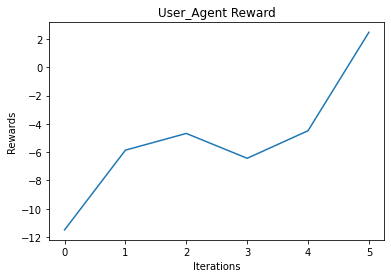

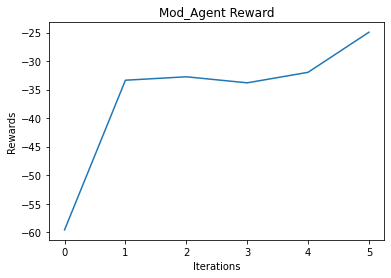

  1%|▉                                                                           | 602/50000 [02:18<3:11:30,  4.30it/s]

Updated Weights
Mean Reward = 3.5000000000000013
29


  1%|█                                                                           | 701/50000 [02:40<3:26:36,  3.98it/s]

Updated Weights
Mean Reward = 2.649000000000001
27


  2%|█▏                                                                          | 801/50000 [03:04<3:47:22,  3.61it/s]

Updated Weights
Mean Reward = 1.598000000000001
31
Saved Weights


  2%|█▎                                                                          | 901/50000 [03:27<3:45:10,  3.63it/s]

Updated Weights
Mean Reward = 3.503000000000002
27


  2%|█▌                                                                         | 1000/50000 [03:48<3:19:25,  4.10it/s]

Updated Weights
Mean Reward = 4.582000000000001
37
Saved Weights


  2%|█▋                                                                         | 1101/50000 [04:14<3:07:39,  4.34it/s]

Updated Weights
Mean Reward = -0.078999999999998
26


  2%|█▊                                                                         | 1201/50000 [04:37<3:22:18,  4.02it/s]

Updated Weights
Mean Reward = 2.493000000000002
34


  3%|█▉                                                                         | 1301/50000 [04:59<3:05:29,  4.38it/s]

Updated Weights
Mean Reward = 0.18800000000000153
14


  3%|██                                                                         | 1401/50000 [05:24<3:28:06,  3.89it/s]

Updated Weights
Mean Reward = -1.8279999999999987
18


  3%|██▎                                                                        | 1500/50000 [05:46<2:51:03,  4.73it/s]

Updated Weights
Mean Reward = 0.3840000000000013
22


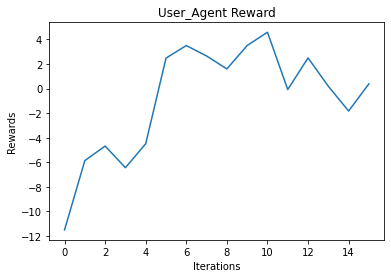

  3%|██▍                                                                        | 1601/50000 [06:11<2:49:45,  4.75it/s]

Updated Weights
Mean Reward = -4.374999999999999
20


  3%|██▌                                                                        | 1701/50000 [06:35<3:18:30,  4.06it/s]

Updated Weights
Mean Reward = 1.2260000000000013
19


  4%|██▋                                                                        | 1801/50000 [07:04<3:32:50,  3.77it/s]

Updated Weights
Mean Reward = 0.37500000000000144
20


  4%|██▊                                                                        | 1902/50000 [07:28<3:00:30,  4.44it/s]

Updated Weights
Mean Reward = 0.519000000000001
23


  4%|███                                                                        | 2000/50000 [07:50<3:15:42,  4.09it/s]

Updated Weights
Mean Reward = 0.09200000000000078
15


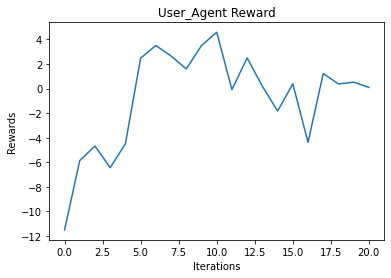

  4%|███▏                                                                       | 2101/50000 [08:18<3:26:22,  3.87it/s]

Updated Weights
Mean Reward = -0.2989999999999988
15


  4%|███▎                                                                       | 2201/50000 [08:45<4:11:39,  3.17it/s]

Updated Weights
Mean Reward = -2.710999999999999
18


  5%|███▍                                                                       | 2301/50000 [09:19<4:56:09,  2.68it/s]

Updated Weights
Mean Reward = -0.9509999999999985
17


  5%|███▌                                                                       | 2401/50000 [09:49<3:24:22,  3.88it/s]

Updated Weights
Mean Reward = 1.8500000000000014
22


  5%|███▊                                                                       | 2500/50000 [10:18<4:17:23,  3.08it/s]

Updated Weights
Mean Reward = 3.8240000000000007
30


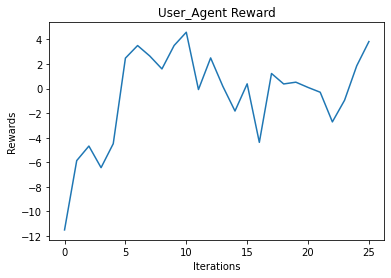

  5%|███▉                                                                       | 2601/50000 [10:49<3:47:40,  3.47it/s]

Updated Weights
Mean Reward = 3.547000000000001
20


  5%|████                                                                       | 2701/50000 [11:23<4:36:02,  2.86it/s]

Updated Weights
Mean Reward = -0.22899999999999882
11


  6%|████▏                                                                      | 2801/50000 [11:55<3:43:29,  3.52it/s]

Updated Weights
Mean Reward = 3.2060000000000017
23


  6%|████▎                                                                      | 2901/50000 [12:25<4:33:04,  2.87it/s]

Updated Weights
Mean Reward = 2.116000000000001
28


  6%|████▌                                                                      | 3000/50000 [12:58<3:04:27,  4.25it/s]

Updated Weights
Mean Reward = -0.42199999999999854
15


  6%|████▋                                                                      | 3101/50000 [13:34<4:54:55,  2.65it/s]

Updated Weights
Mean Reward = 1.662000000000001
20


  6%|████▊                                                                      | 3201/50000 [14:10<4:50:12,  2.69it/s]

Updated Weights
Mean Reward = -1.0519999999999992
18


  7%|████▉                                                                      | 3302/50000 [14:48<3:54:17,  3.32it/s]

Updated Weights
Mean Reward = 2.926000000000002
9


  7%|█████                                                                      | 3401/50000 [15:26<4:55:34,  2.63it/s]

Updated Weights
Mean Reward = -2.8989999999999982
16


  7%|█████▎                                                                     | 3500/50000 [16:04<5:23:42,  2.39it/s]

Updated Weights
Mean Reward = -1.306999999999999
12


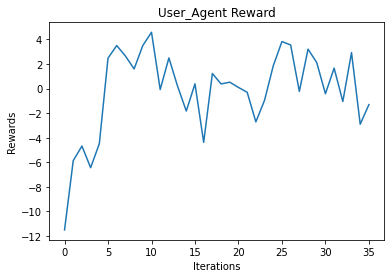

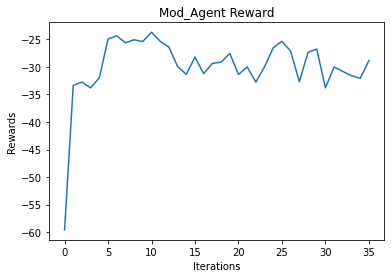

  7%|█████▍                                                                     | 3601/50000 [16:40<4:17:39,  3.00it/s]

Updated Weights
Mean Reward = 2.8250000000000006
22


  7%|█████▌                                                                     | 3701/50000 [17:16<4:27:42,  2.88it/s]

Updated Weights
Mean Reward = 3.6140000000000003
24


  8%|█████▋                                                                     | 3801/50000 [17:51<4:11:00,  3.07it/s]

Updated Weights
Mean Reward = 3.173000000000002
17


  8%|█████▊                                                                     | 3901/50000 [18:29<4:37:00,  2.77it/s]

Updated Weights
Mean Reward = 0.6540000000000016
13


  8%|██████                                                                     | 4000/50000 [19:04<4:14:53,  3.01it/s]

Updated Weights
Mean Reward = 2.020000000000002
21


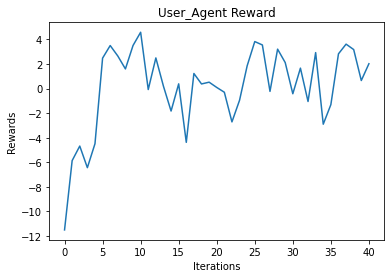

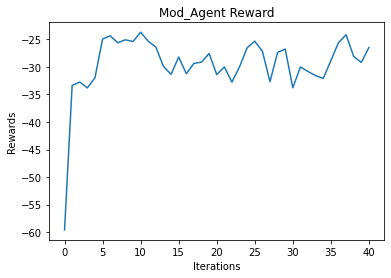

  8%|██████▏                                                                    | 4101/50000 [19:44<5:17:20,  2.41it/s]

Updated Weights
Mean Reward = 1.1620000000000013
12


  8%|██████▎                                                                    | 4201/50000 [20:22<5:05:20,  2.50it/s]

Updated Weights
Mean Reward = 6.967000000000002
30


  9%|██████▍                                                                    | 4301/50000 [21:02<5:06:07,  2.49it/s]

Updated Weights
Mean Reward = -3.9089999999999985
16


  9%|██████▌                                                                    | 4401/50000 [21:41<4:58:41,  2.54it/s]

Updated Weights
Mean Reward = 3.7970000000000015
20


  9%|██████▊                                                                    | 4500/50000 [22:19<5:40:03,  2.23it/s]

Updated Weights
Mean Reward = 5.408
26


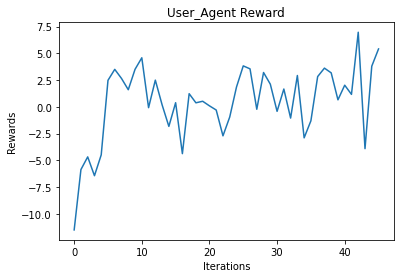

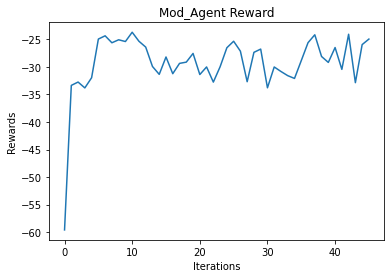

  9%|██████▉                                                                    | 4601/50000 [22:57<4:24:58,  2.86it/s]

Updated Weights
Mean Reward = 5.359000000000002
20


  9%|███████                                                                    | 4701/50000 [23:36<4:34:29,  2.75it/s]

Updated Weights
Mean Reward = 0.8530000000000015
20


 10%|███████▏                                                                   | 4801/50000 [24:14<4:11:54,  2.99it/s]

Updated Weights
Mean Reward = 1.3140000000000012
17


 10%|███████▎                                                                   | 4901/50000 [24:52<4:38:55,  2.69it/s]

Updated Weights
Mean Reward = 4.431000000000003
18


 10%|███████▌                                                                   | 5000/50000 [25:29<4:17:53,  2.91it/s]

Updated Weights
Mean Reward = 4.736000000000002
28


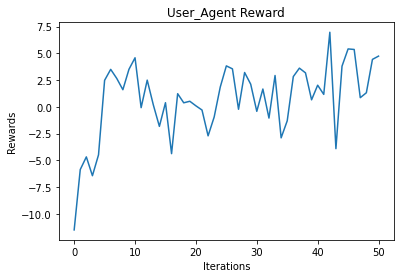

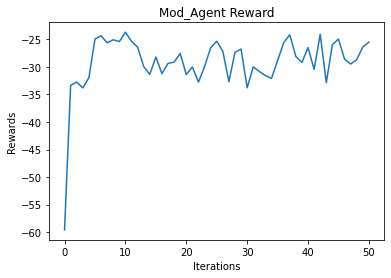

 10%|███████▋                                                                   | 5101/50000 [26:10<5:15:52,  2.37it/s]

Updated Weights
Mean Reward = 3.985000000000001
23


 10%|███████▊                                                                   | 5201/50000 [26:53<5:22:18,  2.32it/s]

Updated Weights
Mean Reward = -2.791999999999999
19


 11%|███████▉                                                                   | 5301/50000 [27:35<5:50:34,  2.13it/s]

Updated Weights
Mean Reward = 1.8810000000000016
19


 11%|████████                                                                   | 5401/50000 [28:19<5:01:28,  2.47it/s]

Updated Weights
Mean Reward = -1.9029999999999985
15


 11%|████████▎                                                                  | 5500/50000 [28:58<5:46:29,  2.14it/s]

Updated Weights
Mean Reward = 3.376000000000002
16


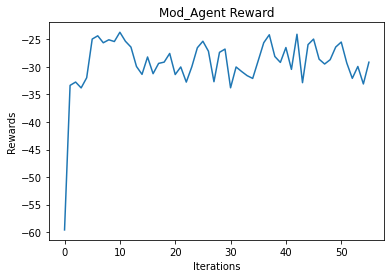

 11%|████████▍                                                                  | 5601/50000 [29:42<5:06:35,  2.41it/s]

Updated Weights
Mean Reward = -2.497999999999999
16


 11%|████████▌                                                                  | 5701/50000 [30:26<5:25:55,  2.27it/s]

Updated Weights
Mean Reward = 7.273000000000003
15


 12%|████████▋                                                                  | 5801/50000 [31:08<5:07:10,  2.40it/s]

Updated Weights
Mean Reward = 11.842000000000002
21


 12%|████████▊                                                                  | 5901/50000 [31:52<5:36:17,  2.19it/s]

Updated Weights
Mean Reward = 6.214000000000003
14


 12%|█████████                                                                  | 6000/50000 [32:25<4:44:33,  2.58it/s]

Updated Weights
Mean Reward = -4.743999999999999
18


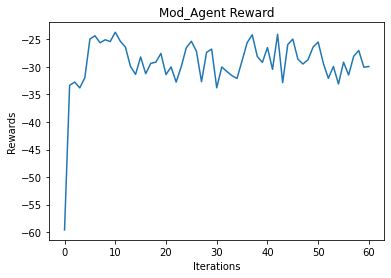

 12%|█████████▏                                                                 | 6101/50000 [33:04<5:55:41,  2.06it/s]

Updated Weights
Mean Reward = 0.04300000000000166
17


 12%|█████████▎                                                                 | 6201/50000 [33:48<5:53:45,  2.06it/s]

Updated Weights
Mean Reward = 4.616000000000001
19


 13%|█████████▍                                                                 | 6301/50000 [34:32<4:15:09,  2.85it/s]

Updated Weights
Mean Reward = 4.0150000000000015
25


 13%|█████████▌                                                                 | 6401/50000 [35:15<4:56:23,  2.45it/s]

Updated Weights
Mean Reward = 6.079000000000002
16


 13%|█████████▊                                                                 | 6500/50000 [35:50<4:35:20,  2.63it/s]

Updated Weights
Mean Reward = 3.541000000000002
24


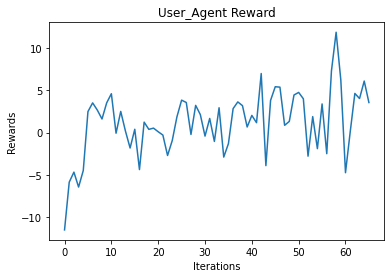

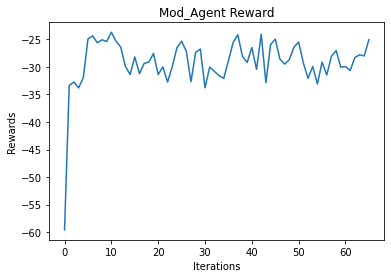

 13%|█████████▉                                                                 | 6601/50000 [36:24<4:44:32,  2.54it/s]

Updated Weights
Mean Reward = 7.044000000000003
27


 13%|██████████                                                                 | 6701/50000 [36:58<4:28:33,  2.69it/s]

Updated Weights
Mean Reward = 0.5610000000000014
26


 14%|██████████▏                                                                | 6801/50000 [37:35<3:48:17,  3.15it/s]

Updated Weights
Mean Reward = 3.366000000000002
14


 14%|██████████▎                                                                | 6901/50000 [38:17<5:29:14,  2.18it/s]

Updated Weights
Mean Reward = 1.9430000000000018
20


 14%|██████████▌                                                                | 7000/50000 [38:59<5:49:51,  2.05it/s]

Updated Weights
Mean Reward = 5.808000000000002
24


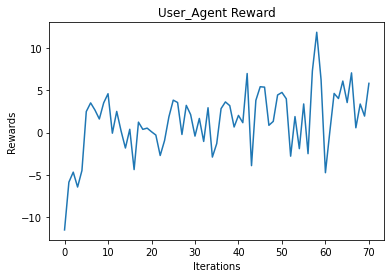

 14%|██████████▋                                                                | 7101/50000 [39:43<5:56:46,  2.00it/s]

Updated Weights
Mean Reward = 4.6960000000000015
35


 14%|██████████▊                                                                | 7201/50000 [40:28<4:49:20,  2.47it/s]

Updated Weights
Mean Reward = 5.629000000000001
31


 15%|██████████▉                                                                | 7301/50000 [41:12<4:59:29,  2.38it/s]

Updated Weights
Mean Reward = 4.961000000000001
28


 15%|███████████                                                                | 7401/50000 [41:55<3:20:56,  3.53it/s]

Updated Weights
Mean Reward = 4.227
31


 15%|███████████▎                                                               | 7500/50000 [42:38<6:05:35,  1.94it/s]

Updated Weights
Mean Reward = 2.2290000000000014
32


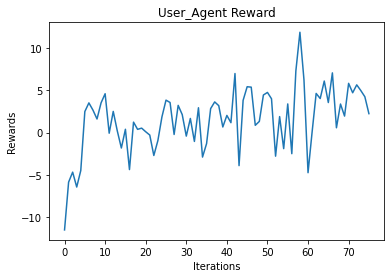

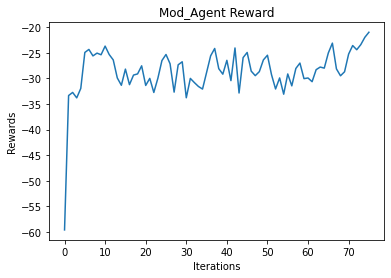

 15%|███████████▍                                                               | 7601/50000 [43:18<5:13:31,  2.25it/s]

Updated Weights
Mean Reward = 1.0860000000000014
29


 15%|███████████▌                                                               | 7701/50000 [43:58<4:48:30,  2.44it/s]

Updated Weights
Mean Reward = 3.3270000000000017
26


 16%|███████████▋                                                               | 7801/50000 [44:37<5:43:43,  2.05it/s]

Updated Weights
Mean Reward = 7.852000000000001
43
Saved Weights


 16%|███████████▊                                                               | 7902/50000 [45:19<4:24:31,  2.65it/s]

Updated Weights
Mean Reward = 7.489000000000003
40


 16%|████████████                                                               | 8000/50000 [46:01<5:29:07,  2.13it/s]

Updated Weights
Mean Reward = 3.7190000000000016
31


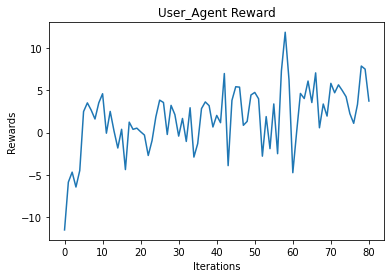

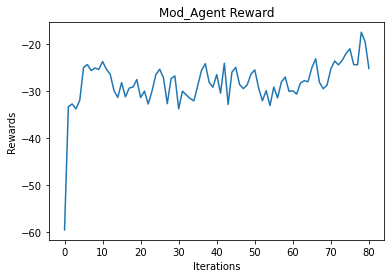

 16%|████████████▏                                                              | 8101/50000 [46:54<8:16:16,  1.41it/s]

Updated Weights
Mean Reward = 2.2840000000000007
13


 16%|████████████▎                                                              | 8201/50000 [47:44<5:42:46,  2.03it/s]

Updated Weights
Mean Reward = 7.417000000000002
27


 17%|████████████▍                                                              | 8301/50000 [48:32<4:58:57,  2.32it/s]

Updated Weights
Mean Reward = 6.122000000000002
25


 17%|████████████▌                                                              | 8401/50000 [49:22<6:13:40,  1.86it/s]

Updated Weights
Mean Reward = 2.341000000000001
19


 17%|████████████▊                                                              | 8500/50000 [50:12<6:21:01,  1.82it/s]

Updated Weights
Mean Reward = -0.5789999999999985
19


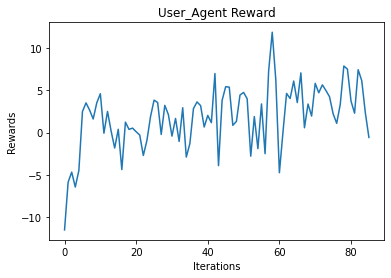

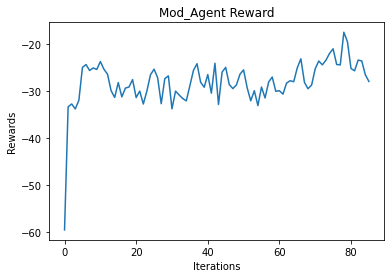

 17%|████████████▉                                                              | 8601/50000 [50:58<4:59:23,  2.30it/s]

Updated Weights
Mean Reward = 5.741000000000001
36


 17%|█████████████                                                              | 8701/50000 [51:48<6:01:45,  1.90it/s]

Updated Weights
Mean Reward = 4.928000000000001
21


 18%|█████████████▏                                                             | 8801/50000 [52:38<5:48:52,  1.97it/s]

Updated Weights
Mean Reward = 4.970000000000002
22


 18%|█████████████▎                                                             | 8901/50000 [53:25<5:41:19,  2.01it/s]

Updated Weights
Mean Reward = 4.216000000000001
24


 18%|█████████████▌                                                             | 9000/50000 [54:14<6:12:04,  1.84it/s]

Updated Weights
Mean Reward = 10.254000000000003
24


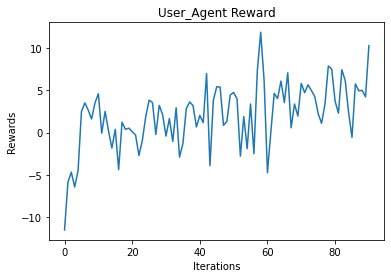

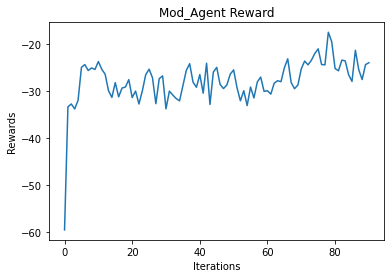

 18%|█████████████▋                                                             | 9101/50000 [55:06<5:52:03,  1.94it/s]

Updated Weights
Mean Reward = 5.182000000000003
19


 18%|█████████████▊                                                             | 9201/50000 [55:51<5:03:39,  2.24it/s]

Updated Weights
Mean Reward = -2.4589999999999987
17


 19%|█████████████▉                                                             | 9302/50000 [56:30<3:40:36,  3.07it/s]

Updated Weights
Mean Reward = 5.392000000000001
33


 19%|██████████████                                                             | 9401/50000 [57:08<3:31:26,  3.20it/s]

Updated Weights
Mean Reward = 8.965000000000002
27


 19%|██████████████▎                                                            | 9500/50000 [57:48<4:41:43,  2.40it/s]

Updated Weights
Mean Reward = 5.350000000000001
15


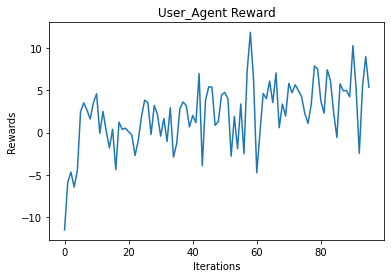

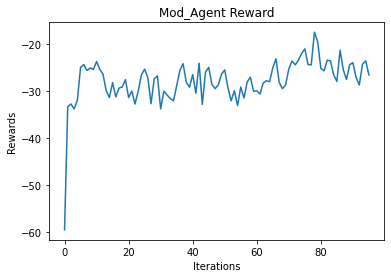

 19%|██████████████▍                                                            | 9601/50000 [58:33<5:38:53,  1.99it/s]

Updated Weights
Mean Reward = 6.193000000000003
16


 19%|██████████████▌                                                            | 9701/50000 [59:12<4:14:32,  2.64it/s]

Updated Weights
Mean Reward = 4.968000000000002
28


 20%|██████████████▋                                                            | 9801/50000 [59:52<5:02:08,  2.22it/s]

Updated Weights
Mean Reward = 2.4840000000000013
19


 20%|██████████████▍                                                          | 9901/50000 [1:00:34<3:53:33,  2.86it/s]

Updated Weights
Mean Reward = 3.9630000000000005
22


 20%|██████████████▍                                                         | 10000/50000 [1:01:14<5:18:20,  2.09it/s]

Updated Weights
Mean Reward = 3.504000000000001
26


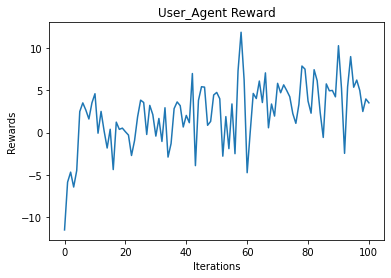

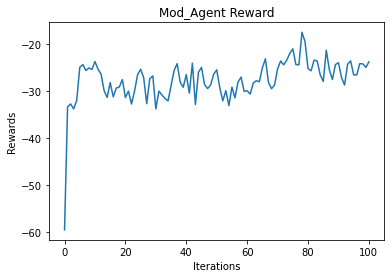

 20%|██████████████▌                                                         | 10101/50000 [1:01:54<4:59:13,  2.22it/s]

Updated Weights
Mean Reward = 4.023000000000001
29


 20%|██████████████▋                                                         | 10201/50000 [1:02:35<4:17:32,  2.58it/s]

Updated Weights
Mean Reward = 6.217000000000002
27


 21%|██████████████▊                                                         | 10301/50000 [1:03:17<5:23:54,  2.04it/s]

Updated Weights
Mean Reward = 3.140000000000001
24


 21%|██████████████▉                                                         | 10401/50000 [1:03:59<5:09:40,  2.13it/s]

Updated Weights
Mean Reward = 6.271000000000003
17


 21%|███████████████                                                         | 10500/50000 [1:04:42<5:22:19,  2.04it/s]

Updated Weights
Mean Reward = 2.633000000000002
13


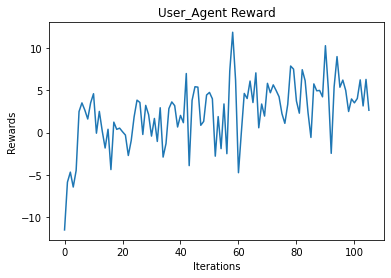

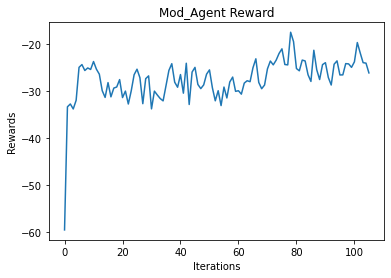

 21%|███████████████▎                                                        | 10601/50000 [1:05:24<4:17:47,  2.55it/s]

Updated Weights
Mean Reward = 4.8690000000000015
28


 21%|███████████████▍                                                        | 10701/50000 [1:06:04<4:09:30,  2.63it/s]

Updated Weights
Mean Reward = 7.254
28


 22%|███████████████▌                                                        | 10800/50000 [1:06:44<3:58:07,  2.74it/s]

Updated Weights
Mean Reward = 9.385000000000002
27


 22%|███████████████▋                                                        | 10901/50000 [1:07:25<5:02:06,  2.16it/s]

Updated Weights
Mean Reward = 1.927000000000001
26


 22%|███████████████▊                                                        | 11000/50000 [1:08:07<4:43:45,  2.29it/s]

Updated Weights
Mean Reward = 9.519000000000004
37


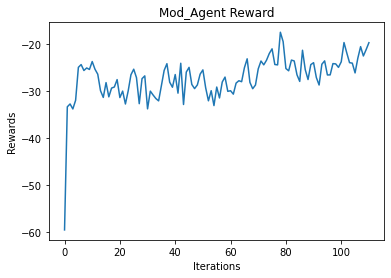

 22%|███████████████▉                                                        | 11101/50000 [1:08:51<5:16:03,  2.05it/s]

Updated Weights
Mean Reward = 3.5870000000000015
20


 22%|████████████████▏                                                       | 11201/50000 [1:09:33<4:49:27,  2.23it/s]

Updated Weights
Mean Reward = 4.779000000000002
20


 23%|████████████████▎                                                       | 11301/50000 [1:10:16<5:19:11,  2.02it/s]

Updated Weights
Mean Reward = 6.365000000000002
22


 23%|████████████████▍                                                       | 11401/50000 [1:11:04<5:00:20,  2.14it/s]

Updated Weights
Mean Reward = 6.160000000000002
10


 23%|████████████████▌                                                       | 11500/50000 [1:11:49<3:08:56,  3.40it/s]

Updated Weights
Mean Reward = 6.111000000000001
21


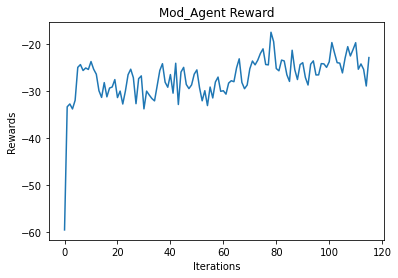

 23%|████████████████▋                                                       | 11601/50000 [1:12:33<5:24:00,  1.98it/s]

Updated Weights
Mean Reward = 5.068000000000001
28


 23%|████████████████▊                                                       | 11701/50000 [1:13:13<4:31:02,  2.36it/s]

Updated Weights
Mean Reward = 6.956
33


 24%|████████████████▉                                                       | 11802/50000 [1:13:53<3:18:40,  3.20it/s]

Updated Weights
Mean Reward = 9.612
33


 24%|█████████████████▏                                                      | 11901/50000 [1:14:44<5:33:13,  1.91it/s]

Updated Weights
Mean Reward = 4.832000000000002
18


 24%|█████████████████▎                                                      | 12000/50000 [1:15:29<5:09:08,  2.05it/s]

Updated Weights
Mean Reward = 4.115000000000002
27


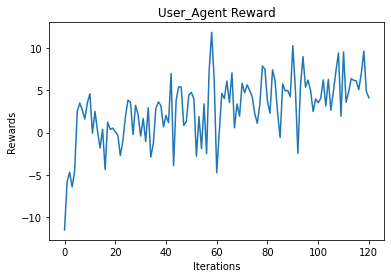

 24%|█████████████████▍                                                      | 12101/50000 [1:16:16<6:01:23,  1.75it/s]

Updated Weights
Mean Reward = 4.442000000000002
21


 24%|█████████████████▌                                                      | 12201/50000 [1:17:03<3:31:52,  2.97it/s]

Updated Weights
Mean Reward = 6.175
28


 25%|█████████████████▋                                                      | 12301/50000 [1:17:49<4:34:37,  2.29it/s]

Updated Weights
Mean Reward = 5.538
27


 25%|█████████████████▊                                                      | 12401/50000 [1:18:35<5:15:11,  1.99it/s]

Updated Weights
Mean Reward = 2.854000000000001
12


 25%|██████████████████                                                      | 12500/50000 [1:19:18<3:20:35,  3.12it/s]

Updated Weights
Mean Reward = 7.317000000000002
24


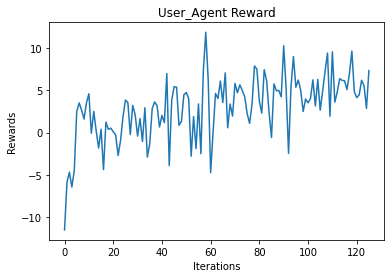

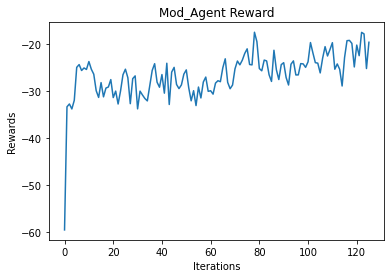

 25%|██████████████████▏                                                     | 12601/50000 [1:20:02<4:57:35,  2.09it/s]

Updated Weights
Mean Reward = 5.993000000000002
25


 25%|██████████████████▎                                                     | 12701/50000 [1:20:45<4:44:13,  2.19it/s]

Updated Weights
Mean Reward = 5.944000000000001
28


 26%|██████████████████▍                                                     | 12801/50000 [1:21:30<4:11:57,  2.46it/s]

Updated Weights
Mean Reward = 4.834000000000001
20


 26%|██████████████████▌                                                     | 12901/50000 [1:22:13<4:20:47,  2.37it/s]

Updated Weights
Mean Reward = 6.759000000000002
22


 26%|██████████████████▋                                                     | 13000/50000 [1:22:55<3:59:17,  2.58it/s]

Updated Weights
Mean Reward = 7.619000000000002
23


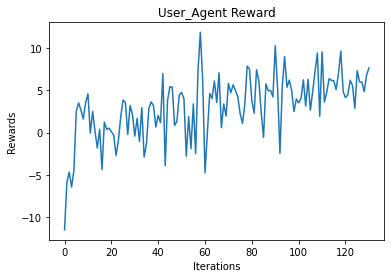

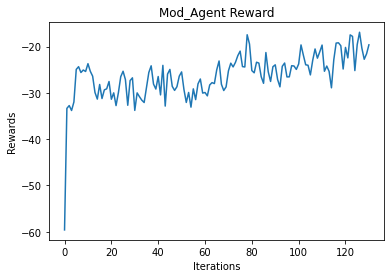

 26%|██████████████████▊                                                     | 13102/50000 [1:23:39<3:17:50,  3.11it/s]

Updated Weights
Mean Reward = 7.379000000000002
29


 26%|███████████████████                                                     | 13201/50000 [1:24:22<4:51:12,  2.11it/s]

Updated Weights
Mean Reward = 6.228000000000003
30


 27%|███████████████████▏                                                    | 13301/50000 [1:25:04<3:49:41,  2.66it/s]

Updated Weights
Mean Reward = 8.308000000000002
33


 27%|███████████████████▎                                                    | 13401/50000 [1:25:49<4:24:10,  2.31it/s]

Updated Weights
Mean Reward = 3.5450000000000017
18


 27%|███████████████████▍                                                    | 13500/50000 [1:26:29<3:25:04,  2.97it/s]

Updated Weights
Mean Reward = 9.044000000000004
32


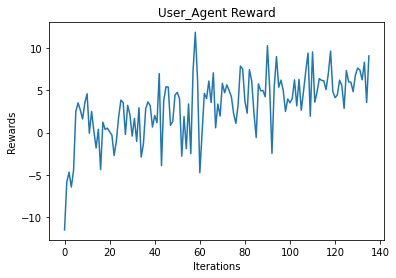

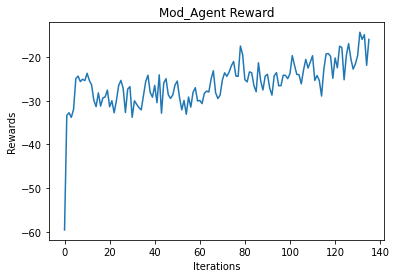

 27%|███████████████████▌                                                    | 13601/50000 [1:27:10<3:49:45,  2.64it/s]

Updated Weights
Mean Reward = 9.188000000000002
36


 27%|███████████████████▋                                                    | 13701/50000 [1:27:52<4:21:32,  2.31it/s]

Updated Weights
Mean Reward = 7.390000000000002
28


 28%|███████████████████▊                                                    | 13801/50000 [1:28:33<4:41:36,  2.14it/s]

Updated Weights
Mean Reward = 11.550000000000004
32


 28%|████████████████████                                                    | 13901/50000 [1:29:15<4:41:04,  2.14it/s]

Updated Weights
Mean Reward = 8.599
23


 28%|████████████████████▏                                                   | 14000/50000 [1:29:59<4:49:59,  2.07it/s]

Updated Weights
Mean Reward = 5.758000000000003
19


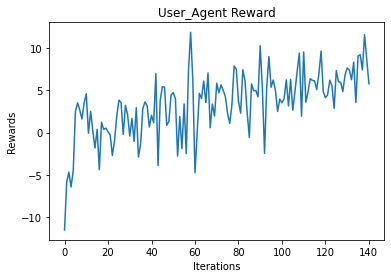

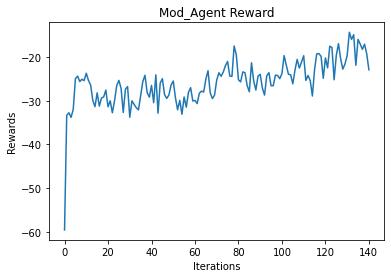

 28%|████████████████████▎                                                   | 14101/50000 [1:30:46<4:04:44,  2.44it/s]

Updated Weights
Mean Reward = 11.444000000000003
23


 28%|████████████████████▍                                                   | 14201/50000 [1:31:31<4:33:30,  2.18it/s]

Updated Weights
Mean Reward = 6.069000000000001
20


 29%|████████████████████▌                                                   | 14301/50000 [1:32:12<4:12:40,  2.35it/s]

Updated Weights
Mean Reward = 9.206000000000003
33


 29%|████████████████████▋                                                   | 14401/50000 [1:32:54<4:54:40,  2.01it/s]

Updated Weights
Mean Reward = 4.995000000000002
32


 29%|████████████████████▉                                                   | 14500/50000 [1:33:39<4:37:00,  2.14it/s]

Updated Weights
Mean Reward = 9.176000000000004
21


 29%|█████████████████████                                                   | 14601/50000 [1:34:24<4:48:38,  2.04it/s]

Updated Weights
Mean Reward = 6.817000000000002
19


 29%|█████████████████████▏                                                  | 14701/50000 [1:35:08<4:17:19,  2.29it/s]

Updated Weights
Mean Reward = 7.630000000000003
29


 30%|█████████████████████▎                                                  | 14801/50000 [1:35:49<4:16:54,  2.28it/s]

Updated Weights
Mean Reward = 9.606000000000002
32


 30%|█████████████████████▍                                                  | 14901/50000 [1:36:32<4:11:34,  2.33it/s]

Updated Weights
Mean Reward = 7.297000000000001
25


 30%|█████████████████████▌                                                  | 15000/50000 [1:37:14<4:22:00,  2.23it/s]

Updated Weights
Mean Reward = 7.929000000000002
27


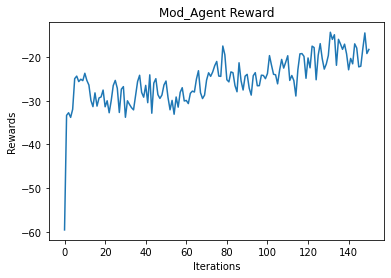

 30%|█████████████████████▋                                                  | 15101/50000 [1:37:56<4:01:01,  2.41it/s]

Updated Weights
Mean Reward = 9.178000000000003
34


 30%|█████████████████████▉                                                  | 15201/50000 [1:38:35<3:15:55,  2.96it/s]

Updated Weights
Mean Reward = 10.052
37


 31%|██████████████████████                                                  | 15302/50000 [1:39:12<2:16:29,  4.24it/s]

Updated Weights
Mean Reward = 7.697000000000002
44
Saved Weights


 31%|██████████████████████▏                                                 | 15401/50000 [1:39:57<4:17:26,  2.24it/s]

Updated Weights
Mean Reward = 7.451000000000001
23


 31%|██████████████████████▎                                                 | 15500/50000 [1:40:40<4:04:11,  2.35it/s]

Updated Weights
Mean Reward = 6.4060000000000015
31


 31%|██████████████████████▍                                                 | 15601/50000 [1:41:22<3:41:20,  2.59it/s]

Updated Weights
Mean Reward = 4.413000000000001
29


 31%|██████████████████████▌                                                 | 15701/50000 [1:42:07<4:24:29,  2.16it/s]

Updated Weights
Mean Reward = 8.739000000000003
15


 32%|██████████████████████▊                                                 | 15801/50000 [1:42:52<3:41:13,  2.58it/s]

Updated Weights
Mean Reward = 6.523000000000001
16


 32%|██████████████████████▉                                                 | 15901/50000 [1:43:40<5:05:25,  1.86it/s]

Updated Weights
Mean Reward = 7.343000000000001
18


 32%|███████████████████████                                                 | 16000/50000 [1:44:23<4:27:09,  2.12it/s]

Updated Weights
Mean Reward = 8.443000000000001
25


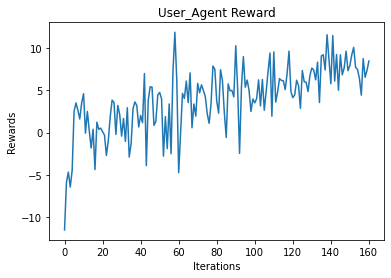

 32%|███████████████████████▏                                                | 16101/50000 [1:45:09<4:36:46,  2.04it/s]

Updated Weights
Mean Reward = 6.062000000000003
19


 32%|███████████████████████▎                                                | 16201/50000 [1:45:51<4:11:18,  2.24it/s]

Updated Weights
Mean Reward = 6.568000000000003
29


 33%|███████████████████████▍                                                | 16300/50000 [1:46:34<4:43:20,  1.98it/s]

Updated Weights
Mean Reward = 5.280000000000002
30


 33%|███████████████████████▌                                                | 16401/50000 [1:47:17<4:48:37,  1.94it/s]

Updated Weights
Mean Reward = 6.5470000000000015
28


 33%|███████████████████████▊                                                | 16500/50000 [1:48:04<4:04:48,  2.28it/s]

Updated Weights
Mean Reward = 6.321000000000001
14


 33%|███████████████████████▉                                                | 16601/50000 [1:48:49<3:54:54,  2.37it/s]

Updated Weights
Mean Reward = 8.683
27


 33%|████████████████████████                                                | 16701/50000 [1:49:35<4:32:38,  2.04it/s]

Updated Weights
Mean Reward = 3.269000000000003
18


 34%|████████████████████████▏                                               | 16801/50000 [1:50:20<4:26:44,  2.07it/s]

Updated Weights
Mean Reward = 8.997
25


 34%|████████████████████████▎                                               | 16901/50000 [1:51:06<3:56:59,  2.33it/s]

Updated Weights
Mean Reward = 10.380000000000003
18


 34%|████████████████████████▍                                               | 17000/50000 [1:51:49<4:21:24,  2.10it/s]

Updated Weights
Mean Reward = 8.598000000000003
30


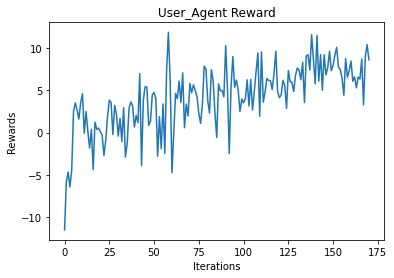

 34%|████████████████████████▋                                               | 17103/50000 [1:52:35<3:03:08,  2.99it/s]

Updated Weights
Mean Reward = 7.806000000000001
19


 34%|████████████████████████▊                                               | 17201/50000 [1:53:23<4:32:28,  2.01it/s]

Updated Weights
Mean Reward = 10.030999999999997
12


 35%|████████████████████████▉                                               | 17301/50000 [1:54:09<4:22:49,  2.07it/s]

Updated Weights
Mean Reward = 14.817999999999998
22


 35%|█████████████████████████                                               | 17401/50000 [1:54:55<4:01:35,  2.25it/s]

Updated Weights
Mean Reward = 5.901000000000002
23


 35%|█████████████████████████▏                                              | 17500/50000 [1:55:40<4:35:00,  1.97it/s]

Updated Weights
Mean Reward = 5.874
20


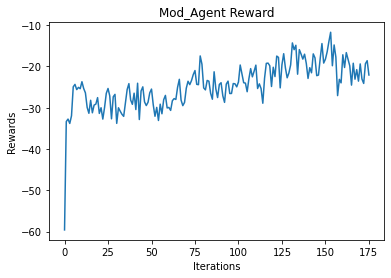

 35%|█████████████████████████▎                                              | 17602/50000 [1:56:26<3:40:20,  2.45it/s]

Updated Weights
Mean Reward = 6.320000000000002
26


 35%|█████████████████████████▍                                              | 17701/50000 [1:57:11<4:40:38,  1.92it/s]

Updated Weights
Mean Reward = 7.341000000000003
26


 36%|█████████████████████████▋                                              | 17801/50000 [1:57:55<3:17:12,  2.72it/s]

Updated Weights
Mean Reward = 8.678000000000003
27


 36%|█████████████████████████▊                                              | 17901/50000 [1:58:35<4:02:22,  2.21it/s]

Updated Weights
Mean Reward = 8.815000000000001
38


 36%|█████████████████████████▉                                              | 18000/50000 [1:59:14<4:27:47,  1.99it/s]

Updated Weights
Mean Reward = 9.152000000000003
34


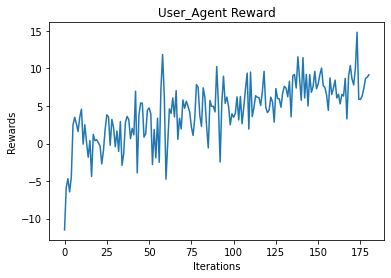

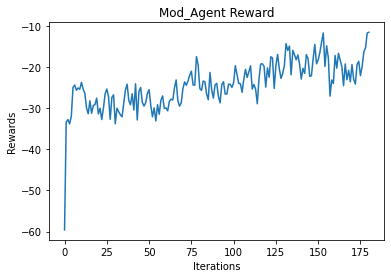

 36%|██████████████████████████                                              | 18101/50000 [1:59:53<4:11:44,  2.11it/s]

Updated Weights
Mean Reward = 10.998000000000005
47
Saved Weights


 36%|██████████████████████████▏                                             | 18201/50000 [2:00:33<4:42:47,  1.87it/s]

Updated Weights
Mean Reward = 3.941000000000002
39


 37%|██████████████████████████▎                                             | 18302/50000 [2:01:16<2:58:01,  2.97it/s]

Updated Weights
Mean Reward = 8.512000000000002
26


 37%|██████████████████████████▍                                             | 18401/50000 [2:01:58<4:16:05,  2.06it/s]

Updated Weights
Mean Reward = 7.141000000000002
35


 37%|██████████████████████████▋                                             | 18500/50000 [2:02:43<4:11:01,  2.09it/s]

Updated Weights
Mean Reward = 10.921000000000001
23


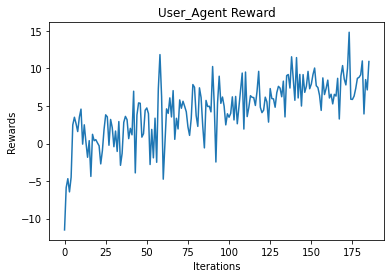

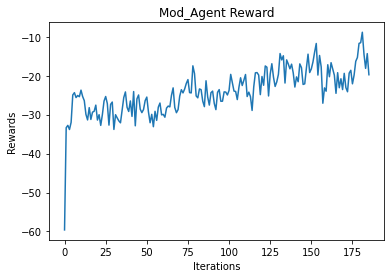

 37%|██████████████████████████▊                                             | 18601/50000 [2:03:31<4:25:08,  1.97it/s]

Updated Weights
Mean Reward = 5.079000000000002
19


 37%|██████████████████████████▉                                             | 18701/50000 [2:04:12<3:22:11,  2.58it/s]

Updated Weights
Mean Reward = 6.337000000000002
37


 38%|███████████████████████████                                             | 18801/50000 [2:04:51<3:42:59,  2.33it/s]

Updated Weights
Mean Reward = 10.314
45


 38%|███████████████████████████▏                                            | 18902/50000 [2:05:30<2:15:11,  3.83it/s]

Updated Weights
Mean Reward = 10.275000000000002
46


 38%|███████████████████████████▎                                            | 19000/50000 [2:06:09<3:52:31,  2.22it/s]

Updated Weights
Mean Reward = 8.327000000000004
40


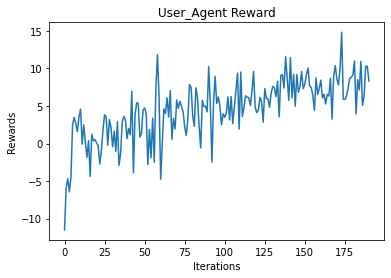

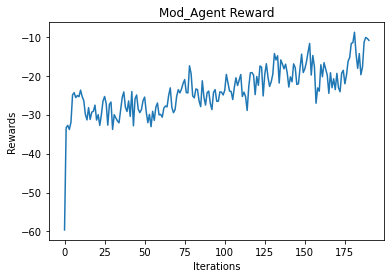

 38%|███████████████████████████▌                                            | 19101/50000 [2:06:49<2:21:34,  3.64it/s]

Updated Weights
Mean Reward = 11.742000000000003
47


 38%|███████████████████████████▋                                            | 19202/50000 [2:07:29<3:09:01,  2.72it/s]

Updated Weights
Mean Reward = 7.400000000000002
44


 39%|███████████████████████████▊                                            | 19301/50000 [2:08:17<4:36:21,  1.85it/s]

Updated Weights
Mean Reward = 9.593000000000002
15


 39%|███████████████████████████▉                                            | 19401/50000 [2:09:04<4:15:05,  2.00it/s]

Updated Weights
Mean Reward = 10.156
22


 39%|████████████████████████████                                            | 19500/50000 [2:09:45<3:27:46,  2.45it/s]

Updated Weights
Mean Reward = 5.629
34


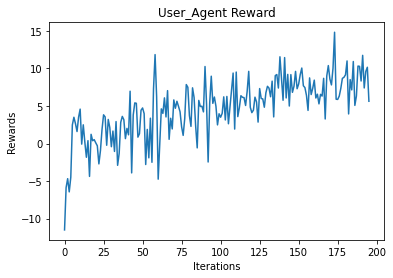

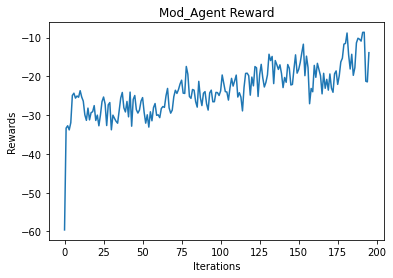

 39%|████████████████████████████▏                                           | 19601/50000 [2:10:27<4:29:19,  1.88it/s]

Updated Weights
Mean Reward = 8.472000000000001
35


 39%|████████████████████████████▎                                           | 19702/50000 [2:11:04<2:06:52,  3.98it/s]

Updated Weights
Mean Reward = 11.117000000000004
50
Saved Weights


 40%|████████████████████████████▌                                           | 19801/50000 [2:11:46<4:17:08,  1.96it/s]

Updated Weights
Mean Reward = 7.206000000000001
36


 40%|████████████████████████████▋                                           | 19901/50000 [2:12:31<4:04:16,  2.05it/s]

Updated Weights
Mean Reward = 7.240000000000004
30


 40%|████████████████████████████▊                                           | 20000/50000 [2:13:15<2:47:41,  2.98it/s]

Updated Weights
Mean Reward = 8.564000000000004
32


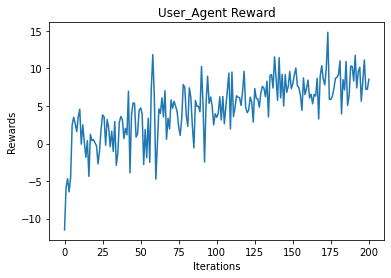

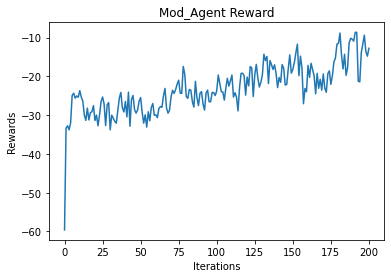

 40%|████████████████████████████▉                                           | 20101/50000 [2:13:55<4:05:16,  2.03it/s]

Updated Weights
Mean Reward = 10.414000000000003
49


 40%|█████████████████████████████                                           | 20201/50000 [2:14:41<4:02:16,  2.05it/s]

Updated Weights
Mean Reward = 8.407000000000002
29


 41%|█████████████████████████████▏                                          | 20301/50000 [2:15:21<3:36:07,  2.29it/s]

Updated Weights
Mean Reward = 9.912
38


 41%|█████████████████████████████▍                                          | 20402/50000 [2:16:03<2:45:38,  2.98it/s]

Updated Weights
Mean Reward = 8.600000000000003
36


 41%|█████████████████████████████▌                                          | 20500/50000 [2:16:41<2:40:37,  3.06it/s]

Updated Weights
Mean Reward = 8.829000000000002
48


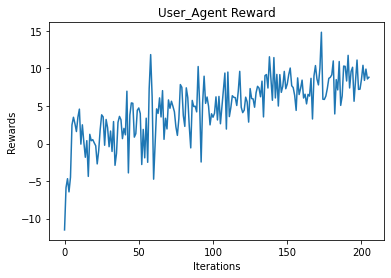

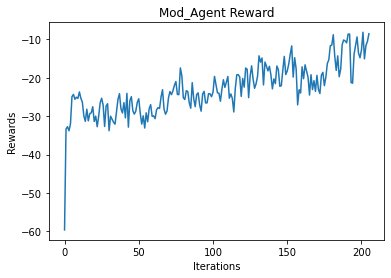

 41%|█████████████████████████████▋                                          | 20601/50000 [2:17:26<3:40:38,  2.22it/s]

Updated Weights
Mean Reward = 10.272000000000002
26


 41%|█████████████████████████████▊                                          | 20701/50000 [2:18:10<4:17:25,  1.90it/s]

Updated Weights
Mean Reward = 8.487
26


 42%|█████████████████████████████▉                                          | 20801/50000 [2:18:46<3:57:33,  2.05it/s]

Updated Weights
Mean Reward = 10.036000000000001
53
Saved Weights


 42%|██████████████████████████████                                          | 20901/50000 [2:19:20<3:45:44,  2.15it/s]

Updated Weights
Mean Reward = 11.232999999999999
55
Saved Weights


 42%|██████████████████████████████▏                                         | 21000/50000 [2:19:57<3:24:04,  2.37it/s]

Updated Weights
Mean Reward = 8.877000000000002
51


 42%|██████████████████████████████▍                                         | 21102/50000 [2:20:42<3:14:44,  2.47it/s]

Updated Weights
Mean Reward = 5.397000000000002
32


 42%|██████████████████████████████▌                                         | 21201/50000 [2:21:24<3:57:13,  2.02it/s]

Updated Weights
Mean Reward = 9.179000000000002
35


 43%|██████████████████████████████▋                                         | 21301/50000 [2:22:13<3:30:20,  2.27it/s]

Updated Weights
Mean Reward = 5.892
16


 43%|██████████████████████████████▊                                         | 21401/50000 [2:23:04<3:27:56,  2.29it/s]

Updated Weights
Mean Reward = 9.028999999999996
17


 43%|██████████████████████████████▉                                         | 21500/50000 [2:23:42<3:37:58,  2.18it/s]

Updated Weights
Mean Reward = 9.440000000000003
44


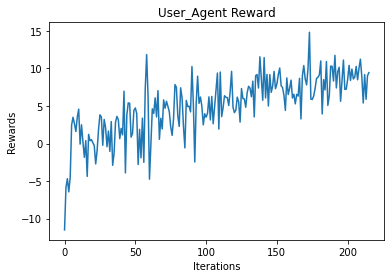

 43%|███████████████████████████████                                         | 21600/50000 [2:24:28<2:39:48,  2.96it/s]

Updated Weights
Mean Reward = 4.939000000000002
24


 43%|███████████████████████████████▏                                        | 21701/50000 [2:25:08<3:31:06,  2.23it/s]

Updated Weights
Mean Reward = 8.389000000000001
41


 44%|███████████████████████████████▍                                        | 21801/50000 [2:25:51<4:13:23,  1.85it/s]

Updated Weights
Mean Reward = 6.474000000000002
35


 44%|███████████████████████████████▌                                        | 21901/50000 [2:26:42<3:52:06,  2.02it/s]

Updated Weights
Mean Reward = 10.224
19


 44%|███████████████████████████████▋                                        | 22000/50000 [2:27:20<3:18:39,  2.35it/s]

Updated Weights
Mean Reward = 9.661000000000001
49


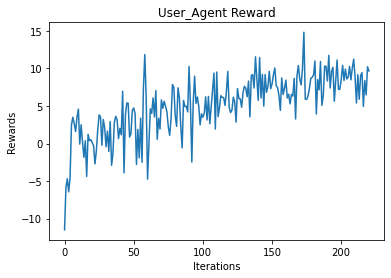

 44%|███████████████████████████████▊                                        | 22101/50000 [2:28:00<3:26:03,  2.26it/s]

Updated Weights
Mean Reward = 7.602000000000003
40


 44%|███████████████████████████████▉                                        | 22201/50000 [2:28:39<2:07:08,  3.64it/s]

Updated Weights
Mean Reward = 9.226
44


 45%|████████████████████████████████                                        | 22302/50000 [2:29:11<2:03:35,  3.74it/s]

Updated Weights
Mean Reward = 11.508000000000003
63
Saved Weights


 45%|████████████████████████████████▎                                       | 22401/50000 [2:29:54<3:42:06,  2.07it/s]

Updated Weights
Mean Reward = 6.490000000000001
36


 45%|████████████████████████████████▍                                       | 22500/50000 [2:30:34<2:58:40,  2.57it/s]

Updated Weights
Mean Reward = 8.921000000000001
43


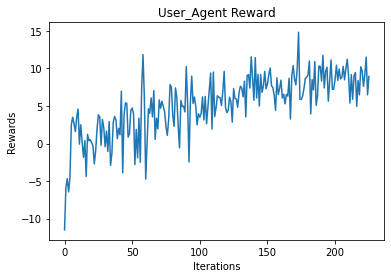

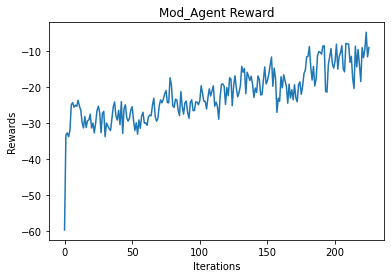

 45%|████████████████████████████████▌                                       | 22601/50000 [2:31:18<2:45:31,  2.76it/s]

Updated Weights
Mean Reward = 8.961000000000002
42


 45%|████████████████████████████████▋                                       | 22701/50000 [2:31:59<2:29:47,  3.04it/s]

Updated Weights
Mean Reward = 9.403000000000002
40


 46%|████████████████████████████████▊                                       | 22801/50000 [2:32:41<2:29:34,  3.03it/s]

Updated Weights
Mean Reward = 15.806999999999999
37


 46%|████████████████████████████████▉                                       | 22900/50000 [2:33:27<4:15:12,  1.77it/s]

Updated Weights
Mean Reward = 0.6920000000000011
26


 46%|█████████████████████████████████                                       | 23000/50000 [2:34:16<3:44:27,  2.00it/s]

Updated Weights
Mean Reward = 13.082999999999997
18


 46%|█████████████████████████████████▎                                      | 23102/50000 [2:35:03<2:10:53,  3.42it/s]

Updated Weights
Mean Reward = 8.219000000000001
33


 46%|█████████████████████████████████▍                                      | 23201/50000 [2:35:45<3:14:27,  2.30it/s]

Updated Weights
Mean Reward = 9.03
46


 47%|█████████████████████████████████▌                                      | 23301/50000 [2:36:28<3:42:06,  2.00it/s]

Updated Weights
Mean Reward = 9.865000000000002
47


 47%|█████████████████████████████████▋                                      | 23401/50000 [2:37:11<3:37:04,  2.04it/s]

Updated Weights
Mean Reward = 9.046000000000001
39


 47%|█████████████████████████████████▊                                      | 23500/50000 [2:37:56<3:45:21,  1.96it/s]

Updated Weights
Mean Reward = 9.306000000000004
38


 47%|█████████████████████████████████▉                                      | 23601/50000 [2:38:36<2:21:53,  3.10it/s]

Updated Weights
Mean Reward = 9.739000000000003
47


 47%|██████████████████████████████████▏                                     | 23702/50000 [2:39:12<2:13:55,  3.27it/s]

Updated Weights
Mean Reward = 10.662000000000004
54


 48%|██████████████████████████████████▎                                     | 23801/50000 [2:39:48<3:55:57,  1.85it/s]

Updated Weights
Mean Reward = 10.457000000000003
53


 48%|██████████████████████████████████▍                                     | 23902/50000 [2:40:24<3:01:03,  2.40it/s]

Updated Weights
Mean Reward = 10.431999999999999
53


 48%|██████████████████████████████████▌                                     | 24000/50000 [2:40:59<3:56:44,  1.83it/s]

Updated Weights
Mean Reward = 7.799000000000002
51


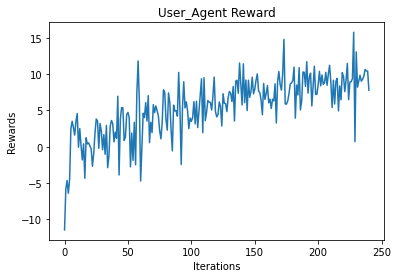

 48%|██████████████████████████████████▋                                     | 24101/50000 [2:41:49<3:17:19,  2.19it/s]

Updated Weights
Mean Reward = 16.681999999999995
19


 48%|██████████████████████████████████▊                                     | 24201/50000 [2:42:29<3:00:03,  2.39it/s]

Updated Weights
Mean Reward = 13.168999999999997
45


 49%|██████████████████████████████████▉                                     | 24301/50000 [2:43:01<1:48:42,  3.94it/s]

Updated Weights
Mean Reward = 11.992000000000003
65
Saved Weights


 49%|███████████████████████████████████▏                                    | 24401/50000 [2:43:33<2:16:09,  3.13it/s]

Updated Weights
Mean Reward = 13.117000000000004
73
Saved Weights


 49%|███████████████████████████████████▎                                    | 24499/50000 [2:43:59<2:37:30,  2.70it/s]

Updated Weights
Mean Reward = 12.932000000000002
78
Saved Weights


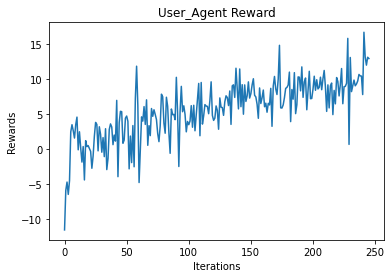

 49%|███████████████████████████████████▍                                    | 24601/50000 [2:44:38<1:39:44,  4.24it/s]

Updated Weights
Mean Reward = 9.728000000000002
49


 49%|███████████████████████████████████▌                                    | 24701/50000 [2:45:07<1:38:31,  4.28it/s]

Updated Weights
Mean Reward = 11.778000000000002
66


 50%|███████████████████████████████████▋                                    | 24801/50000 [2:45:49<3:07:07,  2.24it/s]

Updated Weights
Mean Reward = 8.562000000000005
37


 50%|███████████████████████████████████▊                                    | 24900/50000 [2:46:28<3:46:19,  1.85it/s]

Updated Weights
Mean Reward = 6.847000000000001
54


 50%|████████████████████████████████████                                    | 25000/50000 [2:47:19<3:54:58,  1.77it/s]

Updated Weights
Mean Reward = 14.757999999999996
11


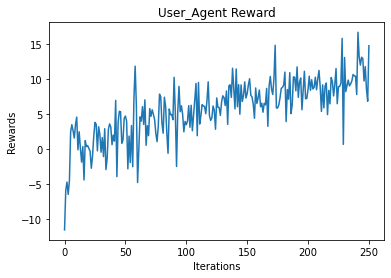

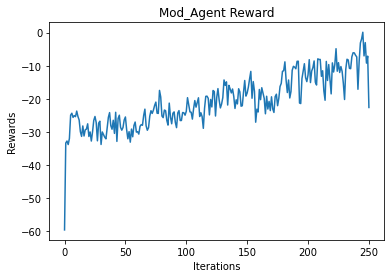

 50%|████████████████████████████████████▏                                   | 25101/50000 [2:48:08<3:16:16,  2.11it/s]

Updated Weights
Mean Reward = 6.094000000000001
23


 50%|████████████████████████████████████▎                                   | 25202/50000 [2:48:49<2:43:32,  2.53it/s]

Updated Weights
Mean Reward = 9.129000000000001
44


 51%|████████████████████████████████████▍                                   | 25301/50000 [2:49:16<1:08:06,  6.04it/s]

Updated Weights
Mean Reward = 12.565
74


 51%|████████████████████████████████████▌                                   | 25401/50000 [2:49:55<2:14:43,  3.04it/s]

Updated Weights
Mean Reward = 7.2940000000000005
47


 51%|████████████████████████████████████▋                                   | 25500/50000 [2:50:31<4:01:48,  1.69it/s]

Updated Weights
Mean Reward = 8.742
52


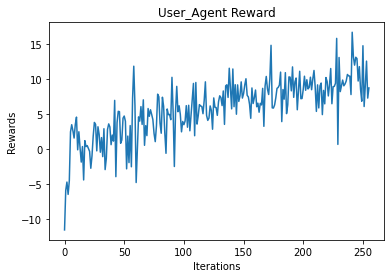

 51%|████████████████████████████████████▊                                   | 25602/50000 [2:51:24<2:35:36,  2.61it/s]

Updated Weights
Mean Reward = 18.251999999999992
12


 51%|█████████████████████████████████████                                   | 25702/50000 [2:52:07<2:28:32,  2.73it/s]

Updated Weights
Mean Reward = 9.003000000000002
39


 52%|█████████████████████████████████████▏                                  | 25802/50000 [2:52:48<2:24:13,  2.80it/s]

Updated Weights
Mean Reward = 7.0230000000000015
41


 52%|█████████████████████████████████████▎                                  | 25900/50000 [2:53:21<2:37:44,  2.55it/s]

Updated Weights
Mean Reward = 10.827000000000004
58


 52%|█████████████████████████████████████▍                                  | 26000/50000 [2:53:58<3:42:45,  1.80it/s]

Updated Weights
Mean Reward = 10.380000000000003
53


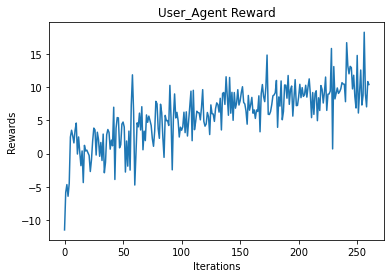

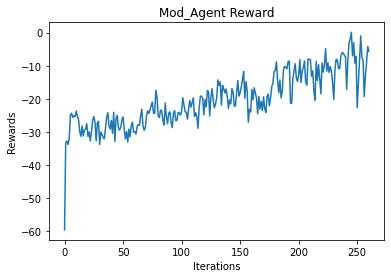

 52%|█████████████████████████████████████▌                                  | 26101/50000 [2:54:31<2:09:50,  3.07it/s]

Updated Weights
Mean Reward = 11.606000000000003
63


 52%|█████████████████████████████████████▋                                  | 26200/50000 [2:55:02<2:00:54,  3.28it/s]

Updated Weights
Mean Reward = 11.179000000000004
62


 53%|█████████████████████████████████████▊                                  | 26301/50000 [2:55:37<3:29:39,  1.88it/s]

Updated Weights
Mean Reward = 10.829000000000002
57


 53%|██████████████████████████████████████                                  | 26401/50000 [2:56:21<2:43:17,  2.41it/s]

Updated Weights
Mean Reward = 3.446000000000002
35


 53%|██████████████████████████████████████▏                                 | 26500/50000 [2:57:14<3:49:05,  1.71it/s]

Updated Weights
Mean Reward = 10.781999999999996
12


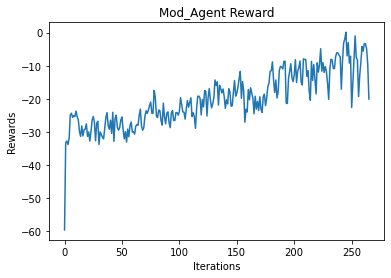

 53%|██████████████████████████████████████▎                                 | 26601/50000 [2:58:04<2:44:41,  2.37it/s]

Updated Weights
Mean Reward = 5.207000000000002
20


 53%|██████████████████████████████████████▍                                 | 26701/50000 [2:58:50<2:46:31,  2.33it/s]

Updated Weights
Mean Reward = 7.266000000000003
30


 54%|██████████████████████████████████████▌                                 | 26801/50000 [2:59:21<3:13:42,  2.00it/s]

Updated Weights
Mean Reward = 11.104000000000003
63


 54%|██████████████████████████████████████▋                                 | 26901/50000 [2:59:58<3:33:11,  1.81it/s]

Updated Weights
Mean Reward = 9.505
50


 54%|██████████████████████████████████████▉                                 | 27000/50000 [3:00:33<1:56:11,  3.30it/s]

Updated Weights
Mean Reward = 8.777000000000001
57


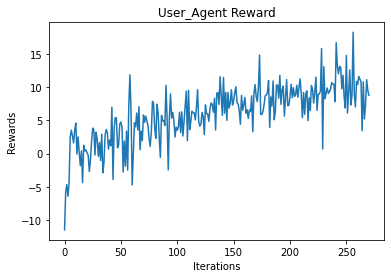

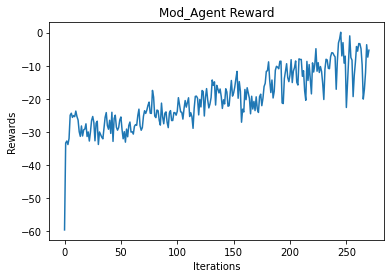

 54%|███████████████████████████████████████                                 | 27101/50000 [3:01:24<3:42:12,  1.72it/s]

Updated Weights
Mean Reward = 4.126000000000002
16


 54%|███████████████████████████████████████▏                                | 27201/50000 [3:02:15<3:16:06,  1.94it/s]

Updated Weights
Mean Reward = 14.321999999999994
16


 55%|███████████████████████████████████████▎                                | 27302/50000 [3:03:03<1:33:09,  4.06it/s]

Updated Weights
Mean Reward = 6.4110000000000005
25


 55%|███████████████████████████████████████▍                                | 27401/50000 [3:03:39<3:27:39,  1.81it/s]

Updated Weights
Mean Reward = 8.379000000000001
52


 55%|███████████████████████████████████████▌                                | 27500/50000 [3:04:31<3:41:22,  1.69it/s]

Updated Weights
Mean Reward = 2.3660000000000014
12


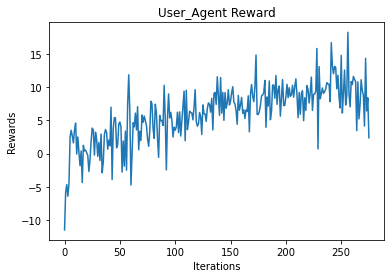

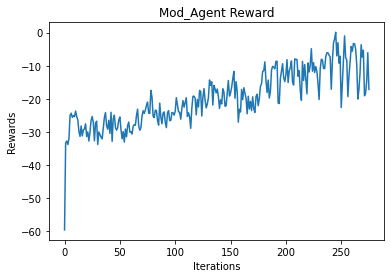

 55%|███████████████████████████████████████▋                                | 27601/50000 [3:05:15<3:07:42,  1.99it/s]

Updated Weights
Mean Reward = 8.314000000000004
39


 55%|███████████████████████████████████████▉                                | 27702/50000 [3:05:55<1:04:55,  5.72it/s]

Updated Weights
Mean Reward = 9.447000000000001
46


 56%|████████████████████████████████████████                                | 27801/50000 [3:06:25<1:46:02,  3.49it/s]

Updated Weights
Mean Reward = 11.145000000000005
65


 56%|████████████████████████████████████████▏                               | 27901/50000 [3:06:56<3:06:41,  1.97it/s]

Updated Weights
Mean Reward = 11.001000000000003
63


 56%|████████████████████████████████████████▎                               | 28000/50000 [3:07:41<2:00:35,  3.04it/s]

Updated Weights
Mean Reward = 6.318000000000003
35


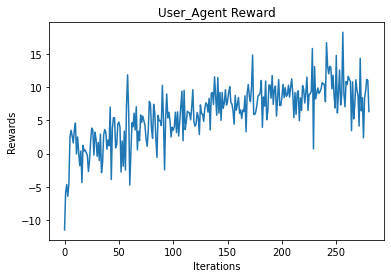

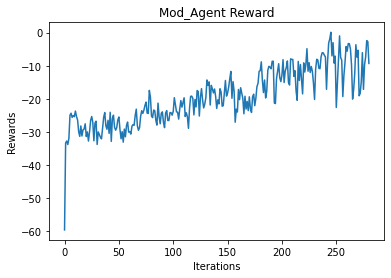

 56%|████████████████████████████████████████▍                               | 28100/50000 [3:08:16<1:08:55,  5.30it/s]

Updated Weights
Mean Reward = 11.304000000000004
60


 56%|████████████████████████████████████████▌                               | 28201/50000 [3:08:46<1:45:46,  3.43it/s]

Updated Weights
Mean Reward = 11.253
66


 57%|████████████████████████████████████████▊                               | 28301/50000 [3:09:21<3:20:13,  1.81it/s]

Updated Weights
Mean Reward = 9.476
53


 57%|████████████████████████████████████████▉                               | 28402/50000 [3:09:57<1:39:38,  3.61it/s]

Updated Weights
Mean Reward = 9.593000000000004
55


 57%|█████████████████████████████████████████                               | 28500/50000 [3:10:35<2:40:47,  2.23it/s]

Updated Weights
Mean Reward = 9.382000000000001
48


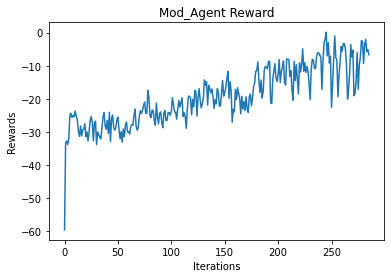

 57%|█████████████████████████████████████████▏                              | 28601/50000 [3:11:19<2:59:02,  1.99it/s]

Updated Weights
Mean Reward = 7.871000000000004
41


 57%|█████████████████████████████████████████▎                              | 28701/50000 [3:12:06<3:19:42,  1.78it/s]

Updated Weights
Mean Reward = 12.343999999999996
25


 58%|█████████████████████████████████████████▍                              | 28802/50000 [3:12:41<1:26:30,  4.08it/s]

Updated Weights
Mean Reward = 9.988000000000001
55


 58%|█████████████████████████████████████████▌                              | 28902/50000 [3:13:13<1:55:55,  3.03it/s]

Updated Weights
Mean Reward = 9.847000000000003
58


 58%|█████████████████████████████████████████▊                              | 29000/50000 [3:13:59<3:08:22,  1.86it/s]

Updated Weights
Mean Reward = 6.642
29


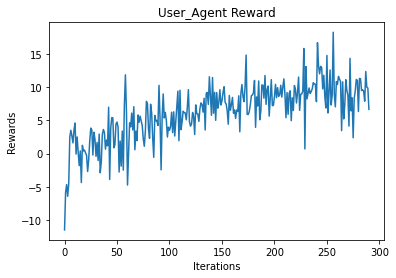

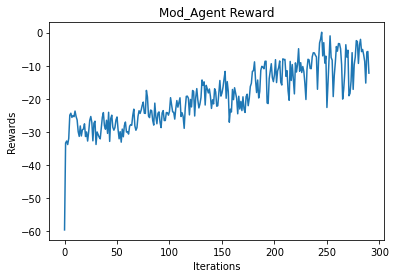

 58%|█████████████████████████████████████████▉                              | 29101/50000 [3:14:49<3:16:35,  1.77it/s]

Updated Weights
Mean Reward = 5.381999999999997
24


 58%|██████████████████████████████████████████                              | 29201/50000 [3:15:41<3:13:31,  1.79it/s]

Updated Weights
Mean Reward = 9.964999999999998
16


 59%|██████████████████████████████████████████▏                             | 29301/50000 [3:16:33<3:23:10,  1.70it/s]

Updated Weights
Mean Reward = 5.866000000000001
15


 59%|██████████████████████████████████████████▎                             | 29401/50000 [3:17:18<3:11:48,  1.79it/s]

Updated Weights
Mean Reward = 7.358000000000001
33


 59%|██████████████████████████████████████████▍                             | 29500/50000 [3:18:00<2:16:07,  2.51it/s]

Updated Weights
Mean Reward = 8.941000000000004
44


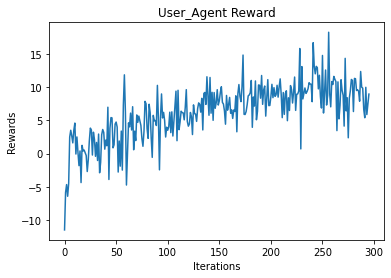

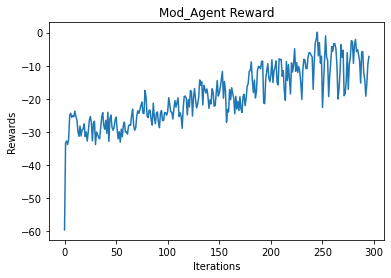

 59%|██████████████████████████████████████████▋                             | 29602/50000 [3:18:37<1:33:46,  3.63it/s]

Updated Weights
Mean Reward = 9.409000000000002
53


 59%|██████████████████████████████████████████▊                             | 29701/50000 [3:19:16<1:46:45,  3.17it/s]

Updated Weights
Mean Reward = 9.946000000000003
50


 60%|██████████████████████████████████████████▉                             | 29802/50000 [3:19:54<1:57:31,  2.86it/s]

Updated Weights
Mean Reward = 9.406
48


 60%|███████████████████████████████████████████                             | 29901/50000 [3:20:27<1:42:04,  3.28it/s]

Updated Weights
Mean Reward = 11.220000000000002
60


 60%|███████████████████████████████████████████▏                            | 30000/50000 [3:21:05<2:14:24,  2.48it/s]

Updated Weights
Mean Reward = 16.850999999999996
47


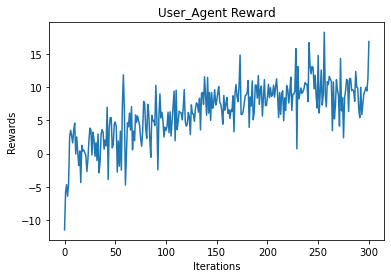

 60%|███████████████████████████████████████████▎                            | 30101/50000 [3:21:41<2:15:08,  2.45it/s]

Updated Weights
Mean Reward = 10.085
57


 60%|███████████████████████████████████████████▍                            | 30201/50000 [3:22:15<2:37:59,  2.09it/s]

Updated Weights
Mean Reward = 9.534
55


 61%|███████████████████████████████████████████▋                            | 30301/50000 [3:23:09<3:06:56,  1.76it/s]

Updated Weights
Mean Reward = 0.8060000000000003
12


 61%|███████████████████████████████████████████▊                            | 30401/50000 [3:23:54<2:33:17,  2.13it/s]

Updated Weights
Mean Reward = 6.8980000000000015
35


 61%|███████████████████████████████████████████▉                            | 30500/50000 [3:24:36<2:36:26,  2.08it/s]

Updated Weights
Mean Reward = 8.486
41


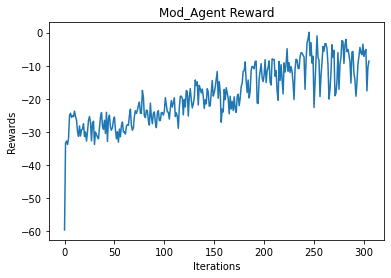

 61%|████████████████████████████████████████████                            | 30602/50000 [3:25:09<1:29:44,  3.60it/s]

Updated Weights
Mean Reward = 10.634
60


 61%|████████████████████████████████████████████▏                           | 30701/50000 [3:25:42<2:27:21,  2.18it/s]

Updated Weights
Mean Reward = 10.259000000000004
58


 62%|████████████████████████████████████████████▎                           | 30802/50000 [3:26:32<2:11:22,  2.44it/s]

Updated Weights
Mean Reward = 3.5530000000000013
22


 62%|████████████████████████████████████████████▍                           | 30901/50000 [3:27:16<2:13:40,  2.38it/s]

Updated Weights
Mean Reward = 7.994000000000001
34


 62%|████████████████████████████████████████████▋                           | 31000/50000 [3:28:02<1:23:03,  3.81it/s]

Updated Weights
Mean Reward = 5.554000000000001
28


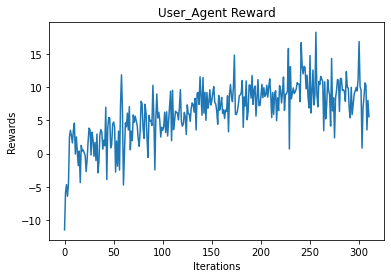

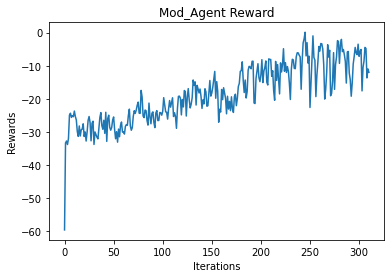

 62%|████████████████████████████████████████████▊                           | 31101/50000 [3:28:46<2:48:02,  1.87it/s]

Updated Weights
Mean Reward = 13.003000000000002
42


 62%|████████████████████████████████████████████▉                           | 31201/50000 [3:29:41<3:12:23,  1.63it/s]

Updated Weights
Mean Reward = 11.750999999999998
23


 63%|█████████████████████████████████████████████                           | 31301/50000 [3:30:32<1:49:15,  2.85it/s]

Updated Weights
Mean Reward = 9.161
36


 63%|█████████████████████████████████████████████▏                          | 31402/50000 [3:31:06<1:18:28,  3.95it/s]

Updated Weights
Mean Reward = 9.814000000000002
56


 63%|█████████████████████████████████████████████▎                          | 31500/50000 [3:31:37<2:16:58,  2.25it/s]

Updated Weights
Mean Reward = 11.080000000000002
63


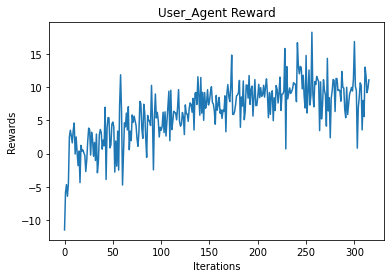

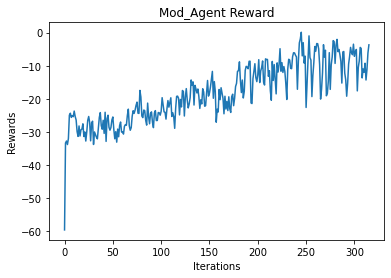

 63%|█████████████████████████████████████████████▌                          | 31601/50000 [3:32:27<2:02:37,  2.50it/s]

Updated Weights
Mean Reward = 3.2900000000000023
21


 63%|█████████████████████████████████████████████▋                          | 31701/50000 [3:33:07<2:18:53,  2.20it/s]

Updated Weights
Mean Reward = 8.830000000000005
46


 64%|███████████████████████████████████████████████                           | 31801/50000 [3:33:48<50:17,  6.03it/s]

Updated Weights
Mean Reward = 9.115000000000002
41


 64%|█████████████████████████████████████████████▉                          | 31901/50000 [3:34:29<2:56:27,  1.71it/s]

Updated Weights
Mean Reward = 10.304
41


 64%|██████████████████████████████████████████████                          | 32000/50000 [3:35:19<2:50:57,  1.75it/s]

Updated Weights
Mean Reward = 5.3850000000000025
23


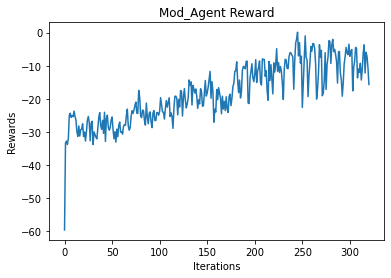

 64%|██████████████████████████████████████████████▏                         | 32102/50000 [3:36:11<1:53:29,  2.63it/s]

Updated Weights
Mean Reward = 11.661999999999995
18


 64%|██████████████████████████████████████████████▎                         | 32201/50000 [3:36:44<1:29:26,  3.32it/s]

Updated Weights
Mean Reward = 10.112
59


 65%|██████████████████████████████████████████████▌                         | 32301/50000 [3:37:20<2:16:18,  2.16it/s]

Updated Weights
Mean Reward = 9.078000000000001
52


 65%|██████████████████████████████████████████████▋                         | 32402/50000 [3:37:53<1:33:15,  3.15it/s]

Updated Weights
Mean Reward = 9.914000000000001
57


 65%|██████████████████████████████████████████████▊                         | 32500/50000 [3:38:36<2:49:27,  1.72it/s]

Updated Weights
Mean Reward = 6.299000000000002
35


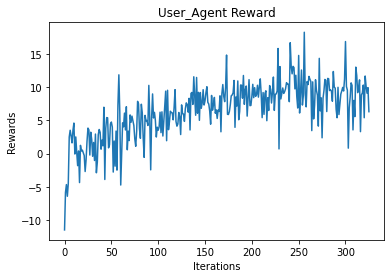

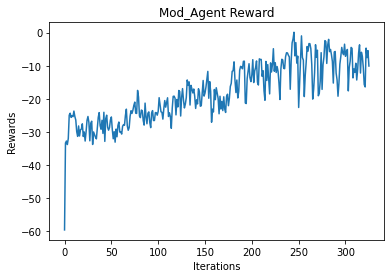

 65%|██████████████████████████████████████████████▉                         | 32601/50000 [3:39:20<1:38:38,  2.94it/s]

Updated Weights
Mean Reward = 5.206000000000001
36


 65%|███████████████████████████████████████████████                         | 32701/50000 [3:39:55<1:58:42,  2.43it/s]

Updated Weights
Mean Reward = 9.948
52


 66%|███████████████████████████████████████████████▏                        | 32801/50000 [3:40:30<1:17:30,  3.70it/s]

Updated Weights
Mean Reward = 10.380999999999998
57


 66%|███████████████████████████████████████████████▍                        | 32902/50000 [3:41:01<1:09:07,  4.12it/s]

Updated Weights
Mean Reward = 10.412
60


 66%|███████████████████████████████████████████████▌                        | 33000/50000 [3:41:34<1:21:43,  3.47it/s]

Updated Weights
Mean Reward = 10.264000000000001
59


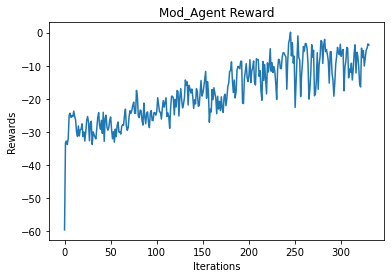

 66%|███████████████████████████████████████████████▋                        | 33101/50000 [3:42:25<2:36:53,  1.80it/s]

Updated Weights
Mean Reward = 4.876000000000002
19


 66%|███████████████████████████████████████████████▊                        | 33201/50000 [3:43:05<2:33:00,  1.83it/s]

Updated Weights
Mean Reward = 8.514000000000003
44


 67%|█████████████████████████████████████████████████▎                        | 33302/50000 [3:43:40<47:16,  5.89it/s]

Updated Weights
Mean Reward = 9.907
54


 67%|████████████████████████████████████████████████                        | 33400/50000 [3:44:09<1:07:09,  4.12it/s]

Updated Weights
Mean Reward = 11.321000000000003
66


 67%|████████████████████████████████████████████████▏                       | 33500/50000 [3:44:41<1:33:23,  2.94it/s]

Updated Weights
Mean Reward = 10.498000000000001
59


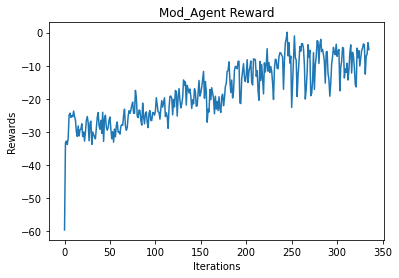

 67%|████████████████████████████████████████████████▍                       | 33601/50000 [3:45:13<2:16:08,  2.01it/s]

Updated Weights
Mean Reward = 10.091999999999999
60


 67%|████████████████████████████████████████████████▌                       | 33701/50000 [3:45:59<1:07:10,  4.04it/s]

Updated Weights
Mean Reward = 6.0870000000000015
31


 68%|████████████████████████████████████████████████▋                       | 33801/50000 [3:46:30<1:51:59,  2.41it/s]

Updated Weights
Mean Reward = 10.369000000000003
60


 68%|████████████████████████████████████████████████▊                       | 33901/50000 [3:47:03<2:10:23,  2.06it/s]

Updated Weights
Mean Reward = 10.464
57


 68%|████████████████████████████████████████████████▉                       | 34000/50000 [3:47:32<1:37:52,  2.72it/s]

Updated Weights
Mean Reward = 11.603000000000002
66


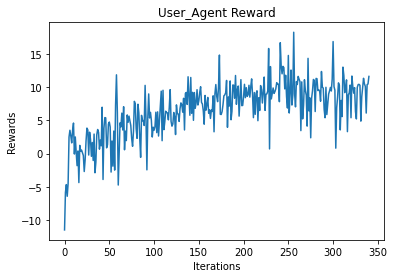

 68%|█████████████████████████████████████████████████                       | 34101/50000 [3:48:25<2:34:21,  1.72it/s]

Updated Weights
Mean Reward = 6.816999999999999
13


 68%|█████████████████████████████████████████████████▏                      | 34201/50000 [3:49:16<1:46:01,  2.48it/s]

Updated Weights
Mean Reward = 20.51699999999999
13


 69%|█████████████████████████████████████████████████▍                      | 34301/50000 [3:50:09<2:07:21,  2.05it/s]

Updated Weights
Mean Reward = 4.524000000000002
15


 69%|█████████████████████████████████████████████████▌                      | 34402/50000 [3:50:51<1:39:33,  2.61it/s]

Updated Weights
Mean Reward = 7.536000000000001
39


 69%|█████████████████████████████████████████████████▋                      | 34500/50000 [3:51:15<1:08:40,  3.76it/s]

Updated Weights
Mean Reward = 11.476
73


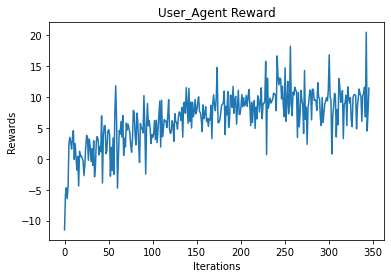

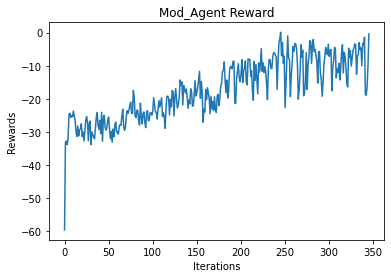

 69%|█████████████████████████████████████████████████▊                      | 34602/50000 [3:51:46<1:08:43,  3.73it/s]

Updated Weights
Mean Reward = 10.838000000000001
66


 69%|█████████████████████████████████████████████████▉                      | 34701/50000 [3:52:28<2:29:19,  1.71it/s]

Updated Weights
Mean Reward = 7.4110000000000005
37


 70%|██████████████████████████████████████████████████                      | 34802/50000 [3:53:12<1:37:34,  2.60it/s]

Updated Weights
Mean Reward = 5.090000000000001
34


 70%|███████████████████████████████████████████████████▋                      | 34902/50000 [3:53:45<48:45,  5.16it/s]

Updated Weights
Mean Reward = 9.982000000000001
58


 70%|██████████████████████████████████████████████████▍                     | 35000/50000 [3:54:20<2:16:17,  1.83it/s]

Updated Weights
Mean Reward = 9.252000000000002
52


 70%|██████████████████████████████████████████████████▌                     | 35101/50000 [3:55:09<1:04:29,  3.85it/s]

Updated Weights
Mean Reward = 2.691000000000001
21


 70%|██████████████████████████████████████████████████▋                     | 35202/50000 [3:55:38<1:14:09,  3.33it/s]

Updated Weights
Mean Reward = 11.676000000000002
70


 71%|██████████████████████████████████████████████████▊                     | 35302/50000 [3:56:08<1:26:50,  2.82it/s]

Updated Weights
Mean Reward = 11.659
67


 71%|██████████████████████████████████████████████████▉                     | 35401/50000 [3:56:38<1:25:58,  2.83it/s]

Updated Weights
Mean Reward = 11.764000000000003
67


 71%|███████████████████████████████████████████████████                     | 35500/50000 [3:57:19<1:23:07,  2.91it/s]

Updated Weights
Mean Reward = 7.940000000000001
38


 71%|███████████████████████████████████████████████████▎                    | 35602/50000 [3:58:00<1:20:03,  3.00it/s]

Updated Weights
Mean Reward = 8.185000000000004
41


 71%|███████████████████████████████████████████████████▍                    | 35701/50000 [3:58:35<1:34:53,  2.51it/s]

Updated Weights
Mean Reward = 10.136000000000001
55


 72%|████████████████████████████████████████████████████▉                     | 35802/50000 [3:59:07<43:17,  5.47it/s]

Updated Weights
Mean Reward = 10.722999999999999
62


 72%|███████████████████████████████████████████████████▋                    | 35901/50000 [3:59:38<1:10:07,  3.35it/s]

Updated Weights
Mean Reward = 10.915000000000003
63


 72%|█████████████████████████████████████████████████████▎                    | 36000/50000 [4:00:10<46:27,  5.02it/s]

Updated Weights
Mean Reward = 10.335
58


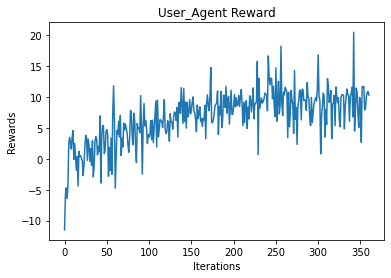

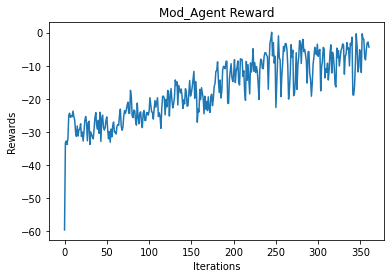

 72%|███████████████████████████████████████████████████▉                    | 36101/50000 [4:00:48<1:20:08,  2.89it/s]

Updated Weights
Mean Reward = 9.391000000000002
51


 72%|█████████████████████████████████████████████████████▌                    | 36201/50000 [4:01:20<42:35,  5.40it/s]

Updated Weights
Mean Reward = 9.927
60


 73%|████████████████████████████████████████████████████▎                   | 36301/50000 [4:01:53<1:18:23,  2.91it/s]

Updated Weights
Mean Reward = 10.969000000000003
58


 73%|████████████████████████████████████████████████████▍                   | 36401/50000 [4:02:32<2:01:05,  1.87it/s]

Updated Weights
Mean Reward = 7.493000000000002
43


 73%|██████████████████████████████████████████████████████                    | 36500/50000 [4:03:00<42:02,  5.35it/s]

Updated Weights
Mean Reward = 12.356
72


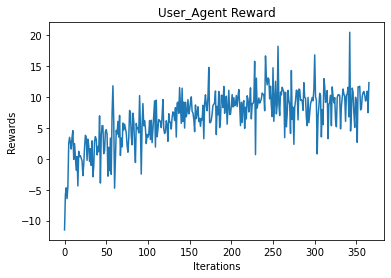

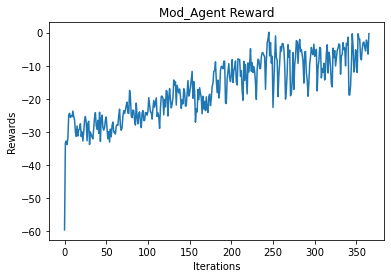

 73%|████████████████████████████████████████████████████▋                   | 36601/50000 [4:03:32<1:17:54,  2.87it/s]

Updated Weights
Mean Reward = 11.022000000000002
61


 73%|████████████████████████████████████████████████████▊                   | 36701/50000 [4:04:06<1:17:59,  2.84it/s]

Updated Weights
Mean Reward = 10.368000000000004
57


 74%|████████████████████████████████████████████████████▉                   | 36801/50000 [4:04:43<1:51:12,  1.98it/s]

Updated Weights
Mean Reward = 9.035000000000002
48


 74%|█████████████████████████████████████████████████████▏                  | 36901/50000 [4:05:19<2:02:52,  1.78it/s]

Updated Weights
Mean Reward = 9.688000000000004
52


 74%|█████████████████████████████████████████████████████▎                  | 37000/50000 [4:06:01<1:41:56,  2.13it/s]

Updated Weights
Mean Reward = 12.204999999999998
35


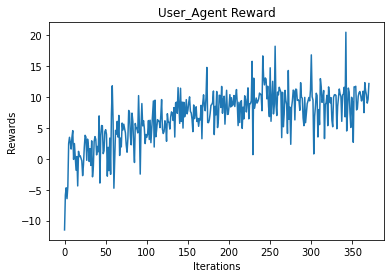

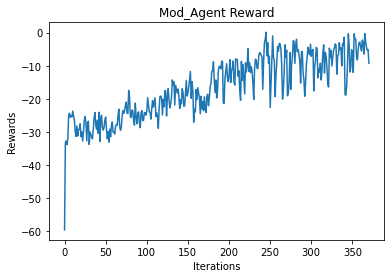

 74%|█████████████████████████████████████████████████████▍                  | 37102/50000 [4:06:35<1:12:46,  2.95it/s]

Updated Weights
Mean Reward = 8.381000000000002
52


 74%|███████████████████████████████████████████████████████                   | 37202/50000 [4:07:04<39:51,  5.35it/s]

Updated Weights
Mean Reward = 11.052000000000003
66


 75%|█████████████████████████████████████████████████████▋                  | 37301/50000 [4:07:34<1:06:54,  3.16it/s]

Updated Weights
Mean Reward = 11.063000000000002
64


 75%|█████████████████████████████████████████████████████▊                  | 37401/50000 [4:08:16<2:01:18,  1.73it/s]

Updated Weights
Mean Reward = 3.9750000000000005
35


 75%|██████████████████████████████████████████████████████                  | 37500/50000 [4:09:06<1:51:24,  1.87it/s]

Updated Weights
Mean Reward = 4.979000000000001
18


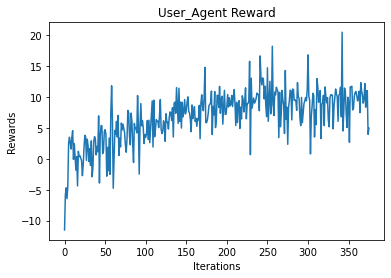

 75%|██████████████████████████████████████████████████████▏                 | 37602/50000 [4:09:47<1:13:32,  2.81it/s]

Updated Weights
Mean Reward = 11.997999999999998
38


 75%|██████████████████████████████████████████████████████▎                 | 37701/50000 [4:10:20<1:49:35,  1.87it/s]

Updated Weights
Mean Reward = 9.898000000000001
57


 76%|██████████████████████████████████████████████████████▍                 | 37802/50000 [4:10:55<1:01:34,  3.30it/s]

Updated Weights
Mean Reward = 9.693000000000003
53


 76%|██████████████████████████████████████████████████████▌                 | 37902/50000 [4:11:27<1:18:17,  2.58it/s]

Updated Weights
Mean Reward = 11.345
60


 76%|██████████████████████████████████████████████████████▋                 | 38000/50000 [4:11:57<1:33:58,  2.13it/s]

Updated Weights
Mean Reward = 11.169000000000006
63


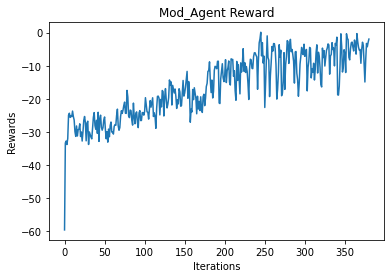

 76%|████████████████████████████████████████████████████████▍                 | 38102/50000 [4:12:28<42:32,  4.66it/s]

Updated Weights
Mean Reward = 11.584000000000001
63


 76%|████████████████████████████████████████████████████████▌                 | 38202/50000 [4:12:58<47:58,  4.10it/s]

Updated Weights
Mean Reward = 12.052000000000003
66


 77%|███████████████████████████████████████████████████████▏                | 38301/50000 [4:13:31<1:26:27,  2.26it/s]

Updated Weights
Mean Reward = 9.751000000000001
56


 77%|███████████████████████████████████████████████████████▎                | 38401/50000 [4:14:09<1:48:10,  1.79it/s]

Updated Weights
Mean Reward = 9.202000000000004
49


 77%|███████████████████████████████████████████████████████▍                | 38500/50000 [4:14:56<1:43:17,  1.86it/s]

Updated Weights
Mean Reward = 5.227000000000003
23


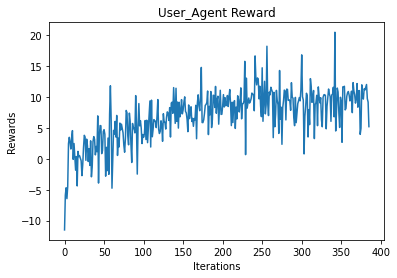

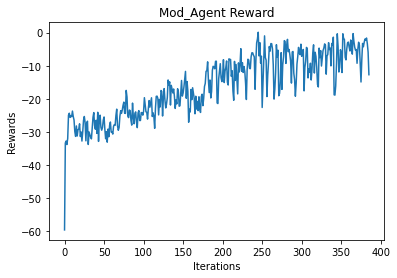

 77%|███████████████████████████████████████████████████████▌                | 38601/50000 [4:15:38<1:12:15,  2.63it/s]

Updated Weights
Mean Reward = 15.781999999999996
37


 77%|█████████████████████████████████████████████████████████▎                | 38702/50000 [4:16:12<37:01,  5.09it/s]

Updated Weights
Mean Reward = 9.427000000000003
56


 78%|█████████████████████████████████████████████████████████▍                | 38801/50000 [4:16:44<38:14,  4.88it/s]

Updated Weights
Mean Reward = 10.513000000000002
59


 78%|████████████████████████████████████████████████████████                | 38901/50000 [4:17:33<1:39:33,  1.86it/s]

Updated Weights
Mean Reward = 6.7620000000000005
23


 78%|████████████████████████████████████████████████████████▏               | 39000/50000 [4:18:12<1:03:49,  2.87it/s]

Updated Weights
Mean Reward = 8.246
42


 78%|████████████████████████████████████████████████████████▎               | 39101/50000 [4:18:47<1:40:02,  1.82it/s]

Updated Weights
Mean Reward = 10.625
55


 78%|██████████████████████████████████████████████████████████                | 39201/50000 [4:19:28<51:00,  3.53it/s]

Updated Weights
Mean Reward = 13.765999999999998
40


 79%|████████████████████████████████████████████████████████▌               | 39301/50000 [4:20:19<1:45:46,  1.69it/s]

Updated Weights
Mean Reward = 6.603
18


 79%|██████████████████████████████████████████████████████████▎               | 39401/50000 [4:21:03<44:49,  3.94it/s]

Updated Weights
Mean Reward = 9.084
33


 79%|████████████████████████████████████████████████████████▉               | 39500/50000 [4:21:41<1:37:21,  1.80it/s]

Updated Weights
Mean Reward = 11.267999999999999
43


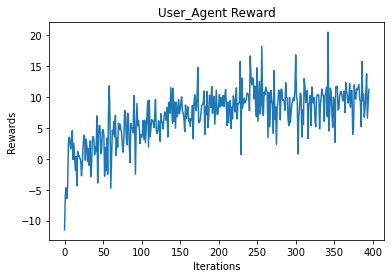

 79%|█████████████████████████████████████████████████████████               | 39601/50000 [4:22:19<1:16:30,  2.27it/s]

Updated Weights
Mean Reward = 8.613000000000001
49


 79%|█████████████████████████████████████████████████████████▏              | 39701/50000 [4:22:53<1:13:50,  2.32it/s]

Updated Weights
Mean Reward = 9.436
55


 80%|██████████████████████████████████████████████████████████▉               | 39802/50000 [4:23:29<56:00,  3.03it/s]

Updated Weights
Mean Reward = 8.543000000000001
51


 80%|█████████████████████████████████████████████████████████▍              | 39901/50000 [4:24:05<1:06:25,  2.53it/s]

Updated Weights
Mean Reward = 8.672000000000002
49


 80%|█████████████████████████████████████████████████████████▌              | 40000/50000 [4:24:38<1:26:48,  1.92it/s]

Updated Weights
Mean Reward = 9.427
58


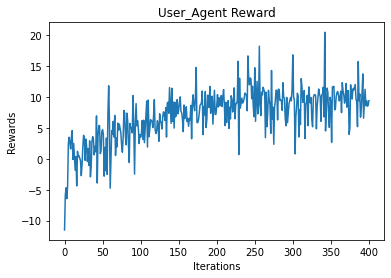

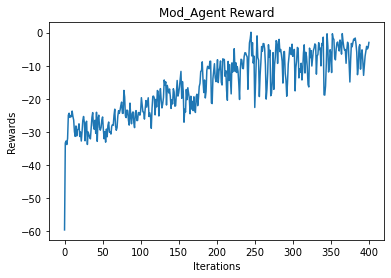

 80%|███████████████████████████████████████████████████████████▎              | 40101/50000 [4:25:21<53:15,  3.10it/s]

Updated Weights
Mean Reward = 6.671
37


 80%|███████████████████████████████████████████████████████████▍              | 40202/50000 [4:25:55<32:42,  4.99it/s]

Updated Weights
Mean Reward = 9.18
54


 81%|███████████████████████████████████████████████████████████▋              | 40302/50000 [4:26:33<53:33,  3.02it/s]

Updated Weights
Mean Reward = 8.15
48


 81%|██████████████████████████████████████████████████████████▏             | 40401/50000 [4:27:19<1:32:02,  1.74it/s]

Updated Weights
Mean Reward = 5.813000000000001
28


 81%|███████████████████████████████████████████████████████████▉              | 40500/50000 [4:27:58<26:29,  5.98it/s]

Updated Weights
Mean Reward = 8.366
39


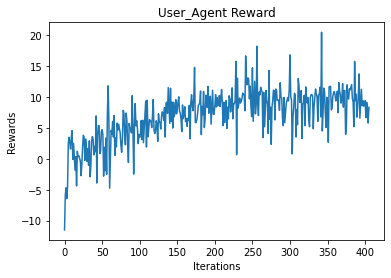

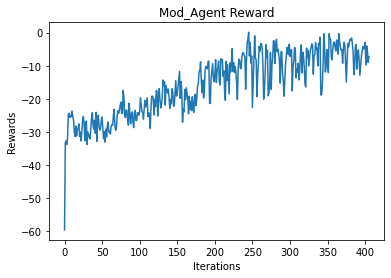

 81%|████████████████████████████████████████████████████████████              | 40603/50000 [4:28:30<34:08,  4.59it/s]

Updated Weights
Mean Reward = 10.700000000000003
65


 81%|████████████████████████████████████████████████████████████▏             | 40701/50000 [4:29:01<49:03,  3.16it/s]

Updated Weights
Mean Reward = 10.099
61


 82%|████████████████████████████████████████████████████████████▍             | 40801/50000 [4:29:35<55:23,  2.77it/s]

Updated Weights
Mean Reward = 8.86
55


 82%|████████████████████████████████████████████████████████████▌             | 40902/50000 [4:30:05<33:01,  4.59it/s]

Updated Weights
Mean Reward = 11.043000000000001
65


 82%|███████████████████████████████████████████████████████████             | 41000/50000 [4:30:36<1:00:50,  2.47it/s]

Updated Weights
Mean Reward = 10.442
62


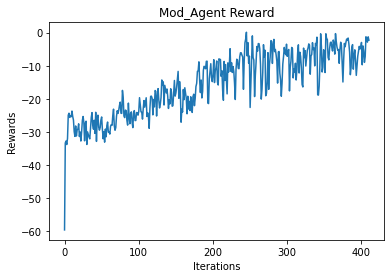

 82%|████████████████████████████████████████████████████████████▊             | 41101/50000 [4:31:05<45:04,  3.29it/s]

Updated Weights
Mean Reward = 10.769
65


 82%|████████████████████████████████████████████████████████████▉             | 41202/50000 [4:31:41<42:16,  3.47it/s]

Updated Weights
Mean Reward = 10.108000000000002
54


 83%|█████████████████████████████████████████████████████████████▏            | 41302/50000 [4:32:13<49:01,  2.96it/s]

Updated Weights
Mean Reward = 9.96
59


 83%|█████████████████████████████████████████████████████████████▎            | 41402/50000 [4:32:45<42:20,  3.38it/s]

Updated Weights
Mean Reward = 11.699000000000003
64


 83%|█████████████████████████████████████████████████████████████▍            | 41500/50000 [4:33:18<57:11,  2.48it/s]

Updated Weights
Mean Reward = 10.845000000000002
59


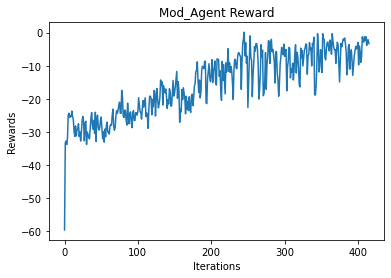

 83%|█████████████████████████████████████████████████████████████▌            | 41601/50000 [4:33:54<56:50,  2.46it/s]

Updated Weights
Mean Reward = 10.14
54


 83%|████████████████████████████████████████████████████████████            | 41701/50000 [4:34:29<1:20:48,  1.71it/s]

Updated Weights
Mean Reward = 9.822000000000003
52


 84%|█████████████████████████████████████████████████████████████▊            | 41802/50000 [4:35:04<57:38,  2.37it/s]

Updated Weights
Mean Reward = 9.98
55


 84%|████████████████████████████████████████████████████████████▎           | 41901/50000 [4:35:53<1:17:49,  1.73it/s]

Updated Weights
Mean Reward = 5.536000000000001
21


 84%|██████████████████████████████████████████████████████████████▏           | 42000/50000 [4:36:35<33:37,  3.96it/s]

Updated Weights
Mean Reward = 6.567000000000002
35


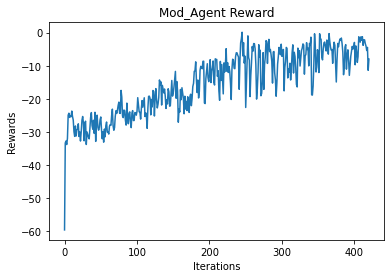

 84%|██████████████████████████████████████████████████████████████▎           | 42102/50000 [4:37:15<39:57,  3.29it/s]

Updated Weights
Mean Reward = 9.829
44


 84%|██████████████████████████████████████████████████████████████▍           | 42201/50000 [4:37:43<59:07,  2.20it/s]

Updated Weights
Mean Reward = 10.529000000000002
67


 85%|██████████████████████████████████████████████████████████████▌           | 42301/50000 [4:38:21<37:52,  3.39it/s]

Updated Weights
Mean Reward = 12.256999999999998
44


 85%|██████████████████████████████████████████████████████████████▊           | 42401/50000 [4:39:08<53:25,  2.37it/s]

Updated Weights
Mean Reward = 5.995000000000001
26


 85%|██████████████████████████████████████████████████████████████▉           | 42500/50000 [4:39:52<52:00,  2.40it/s]

Updated Weights
Mean Reward = 3.426
31


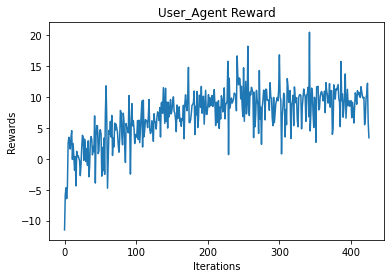

 85%|███████████████████████████████████████████████████████████████           | 42601/50000 [4:40:37<57:26,  2.15it/s]

Updated Weights
Mean Reward = 6.395
35


 85%|█████████████████████████████████████████████████████████████▍          | 42701/50000 [4:41:32<1:10:08,  1.73it/s]

Updated Weights
Mean Reward = 10.316999999999997
10


 86%|███████████████████████████████████████████████████████████████▎          | 42801/50000 [4:42:20<37:17,  3.22it/s]

Updated Weights
Mean Reward = 10.972999999999995
26


 86%|███████████████████████████████████████████████████████████████▍          | 42901/50000 [4:42:54<53:33,  2.21it/s]

Updated Weights
Mean Reward = 9.916000000000002
57


 86%|███████████████████████████████████████████████████████████████▋          | 42999/50000 [4:43:26<34:37,  3.37it/s]

Updated Weights
Mean Reward = 10.080000000000002
58


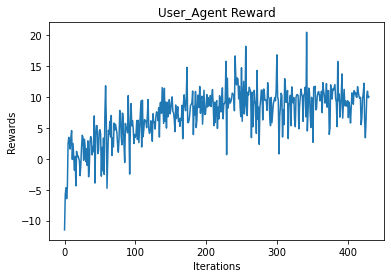

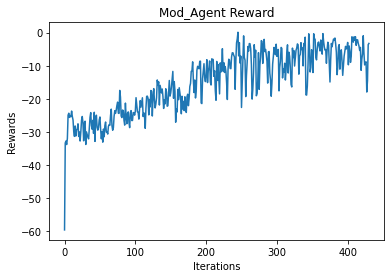

 86%|███████████████████████████████████████████████████████████████▊          | 43101/50000 [4:44:02<54:03,  2.13it/s]

Updated Weights
Mean Reward = 9.614000000000003
54


 86%|███████████████████████████████████████████████████████████████▉          | 43202/50000 [4:44:32<31:47,  3.56it/s]

Updated Weights
Mean Reward = 10.194000000000003
63


 87%|██████████████████████████████████████████████████████████████▎         | 43301/50000 [4:45:09<1:05:27,  1.71it/s]

Updated Weights
Mean Reward = 8.496000000000002
49


 87%|██████████████████████████████████████████████████████████████▍         | 43401/50000 [4:45:59<1:03:13,  1.74it/s]

Updated Weights
Mean Reward = 12.134999999999996
19


 87%|████████████████████████████████████████████████████████████████▍         | 43500/50000 [4:46:37<51:18,  2.11it/s]

Updated Weights
Mean Reward = 7.715000000000001
45


 87%|████████████████████████████████████████████████████████████████▌         | 43602/50000 [4:47:14<40:54,  2.61it/s]

Updated Weights
Mean Reward = 9.662000000000003
54


 87%|████████████████████████████████████████████████████████████████▋         | 43702/50000 [4:47:47<34:37,  3.03it/s]

Updated Weights
Mean Reward = 10.114000000000003
57


 88%|████████████████████████████████████████████████████████████████▊         | 43802/50000 [4:48:20<35:38,  2.90it/s]

Updated Weights
Mean Reward = 10.421000000000003
57


 88%|████████████████████████████████████████████████████████████████▉         | 43902/50000 [4:48:52<15:53,  6.39it/s]

Updated Weights
Mean Reward = 10.247
60


 88%|█████████████████████████████████████████████████████████████████         | 44000/50000 [4:49:22<23:54,  4.18it/s]

Updated Weights
Mean Reward = 10.848000000000003
63


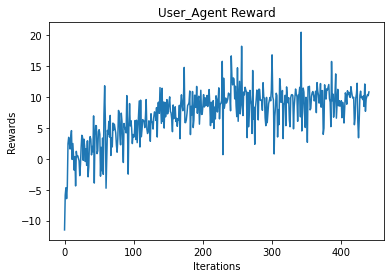

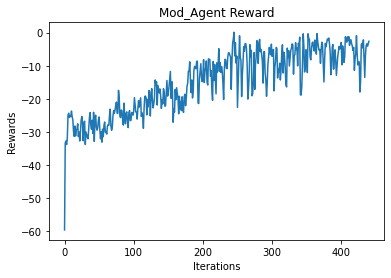

 88%|█████████████████████████████████████████████████████████████████▎        | 44101/50000 [4:49:50<47:31,  2.07it/s]

Updated Weights
Mean Reward = 11.184000000000003
69


 88%|█████████████████████████████████████████████████████████████████▍        | 44201/50000 [4:50:38<32:05,  3.01it/s]

Updated Weights
Mean Reward = 4.456000000000002
26


 89%|█████████████████████████████████████████████████████████████████▌        | 44303/50000 [4:51:07<20:00,  4.75it/s]

Updated Weights
Mean Reward = 12.193000000000005
69


 89%|█████████████████████████████████████████████████████████████████▋        | 44401/50000 [4:51:45<53:51,  1.73it/s]

Updated Weights
Mean Reward = 8.799000000000003
47


 89%|█████████████████████████████████████████████████████████████████▊        | 44500/50000 [4:52:16<30:53,  2.97it/s]

Updated Weights
Mean Reward = 11.253
64


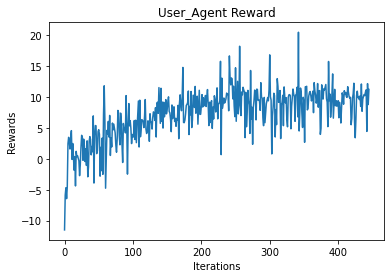

 89%|██████████████████████████████████████████████████████████████████        | 44602/50000 [4:52:49<32:21,  2.78it/s]

Updated Weights
Mean Reward = 10.748000000000005
61


 89%|██████████████████████████████████████████████████████████████████▏       | 44702/50000 [4:53:19<15:04,  5.86it/s]

Updated Weights
Mean Reward = 12.028000000000004
66


 90%|██████████████████████████████████████████████████████████████████▎       | 44802/50000 [4:53:47<10:55,  7.93it/s]

Updated Weights
Mean Reward = 11.527000000000001
68


 90%|██████████████████████████████████████████████████████████████████▍       | 44902/50000 [4:54:17<28:05,  3.03it/s]

Updated Weights
Mean Reward = 10.824000000000002
65


 90%|██████████████████████████████████████████████████████████████████▌       | 45000/50000 [4:54:51<27:36,  3.02it/s]

Updated Weights
Mean Reward = 10.081000000000003
57


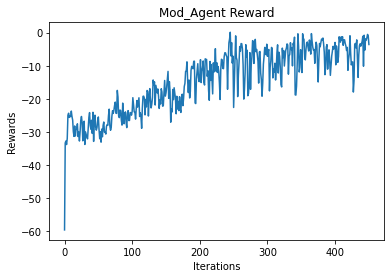

 90%|██████████████████████████████████████████████████████████████████▊       | 45102/50000 [4:55:18<20:16,  4.03it/s]

Updated Weights
Mean Reward = 11.737
72


 90%|██████████████████████████████████████████████████████████████████▉       | 45201/50000 [4:55:52<26:50,  2.98it/s]

Updated Weights
Mean Reward = 9.466000000000001
56


 91%|███████████████████████████████████████████████████████████████████       | 45301/50000 [4:56:21<28:26,  2.75it/s]

Updated Weights
Mean Reward = 10.617
65


 91%|███████████████████████████████████████████████████████████████████▏      | 45401/50000 [4:56:53<24:37,  3.11it/s]

Updated Weights
Mean Reward = 10.777000000000003
61


 91%|███████████████████████████████████████████████████████████████████▎      | 45499/50000 [4:57:22<32:38,  2.30it/s]

Updated Weights
Mean Reward = 10.830000000000002
64


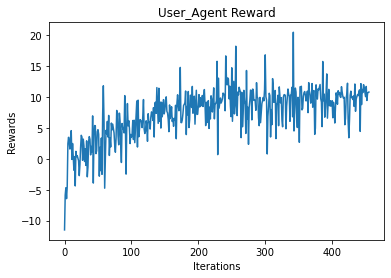

 91%|███████████████████████████████████████████████████████████████████▍      | 45601/50000 [4:57:57<15:22,  4.77it/s]

Updated Weights
Mean Reward = 9.094000000000001
53


 91%|███████████████████████████████████████████████████████████████████▋      | 45701/50000 [4:58:31<20:13,  3.54it/s]

Updated Weights
Mean Reward = 10.549000000000003
58


 92%|███████████████████████████████████████████████████████████████████▊      | 45802/50000 [4:59:01<18:31,  3.78it/s]

Updated Weights
Mean Reward = 10.656000000000004
63


 92%|███████████████████████████████████████████████████████████████████▉      | 45902/50000 [4:59:33<25:31,  2.68it/s]

Updated Weights
Mean Reward = 11.078000000000005
63


 92%|████████████████████████████████████████████████████████████████████      | 45999/50000 [4:59:59<29:03,  2.29it/s]

Updated Weights
Mean Reward = 12.437000000000001
73


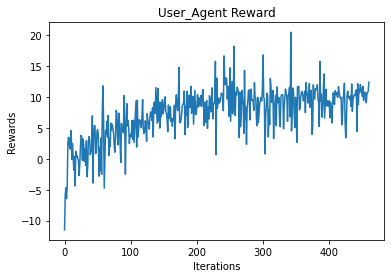

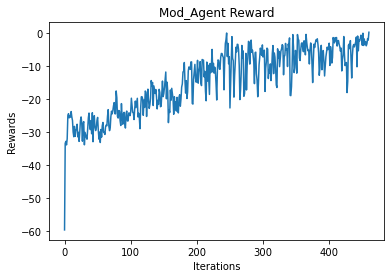

 92%|████████████████████████████████████████████████████████████████████▏     | 46101/50000 [5:00:32<21:37,  3.00it/s]

Updated Weights
Mean Reward = 10.661000000000001
59


 92%|████████████████████████████████████████████████████████████████████▍     | 46201/50000 [5:01:05<25:53,  2.45it/s]

Updated Weights
Mean Reward = 10.599000000000004
58


 93%|████████████████████████████████████████████████████████████████████▌     | 46301/50000 [5:01:35<22:25,  2.75it/s]

Updated Weights
Mean Reward = 11.824000000000003
65


 93%|████████████████████████████████████████████████████████████████████▋     | 46401/50000 [5:02:06<21:45,  2.76it/s]

Updated Weights
Mean Reward = 11.543
63


 93%|████████████████████████████████████████████████████████████████████▊     | 46499/50000 [5:02:46<30:20,  1.92it/s]

Updated Weights
Mean Reward = 8.257000000000001
40


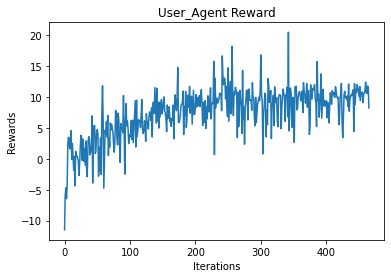

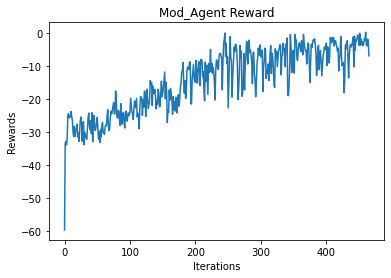

 93%|████████████████████████████████████████████████████████████████████▉     | 46601/50000 [5:03:22<19:07,  2.96it/s]

Updated Weights
Mean Reward = 10.344000000000003
56


 93%|█████████████████████████████████████████████████████████████████████     | 46701/50000 [5:03:43<08:24,  6.54it/s]

Updated Weights
Mean Reward = 13.354000000000001
82
Saved Weights


 94%|█████████████████████████████████████████████████████████████████████▎    | 46801/50000 [5:04:18<20:39,  2.58it/s]

Updated Weights
Mean Reward = 10.777000000000003
55


 94%|█████████████████████████████████████████████████████████████████████▍    | 46901/50000 [5:04:57<26:58,  1.91it/s]

Updated Weights
Mean Reward = 8.923000000000002
47


 94%|█████████████████████████████████████████████████████████████████████▌    | 47000/50000 [5:05:29<19:24,  2.58it/s]

Updated Weights
Mean Reward = 11.262
63


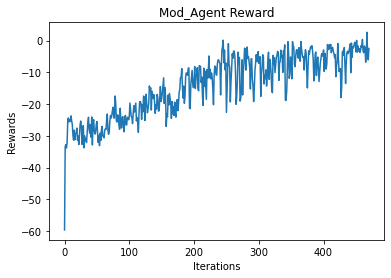

 94%|█████████████████████████████████████████████████████████████████████▋    | 47101/50000 [5:05:57<08:51,  5.45it/s]

Updated Weights
Mean Reward = 12.201
71


 94%|█████████████████████████████████████████████████████████████████████▊    | 47201/50000 [5:06:27<17:18,  2.70it/s]

Updated Weights
Mean Reward = 10.597000000000003
62


 95%|██████████████████████████████████████████████████████████████████████    | 47302/50000 [5:06:58<09:45,  4.61it/s]

Updated Weights
Mean Reward = 10.904000000000002
61


 95%|██████████████████████████████████████████████████████████████████████▏   | 47402/50000 [5:07:30<12:43,  3.40it/s]

Updated Weights
Mean Reward = 10.871000000000002
61


 95%|██████████████████████████████████████████████████████████████████████▎   | 47500/50000 [5:07:57<07:16,  5.73it/s]

Updated Weights
Mean Reward = 11.624000000000002
70


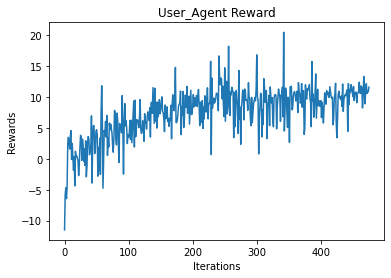

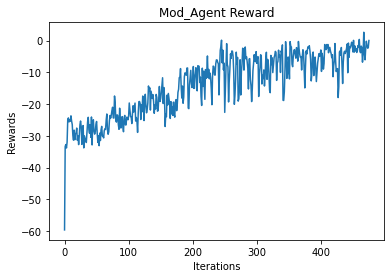

 95%|██████████████████████████████████████████████████████████████████████▍   | 47602/50000 [5:08:25<15:51,  2.52it/s]

Updated Weights
Mean Reward = 12.352
71


 95%|██████████████████████████████████████████████████████████████████████▌   | 47702/50000 [5:08:55<11:10,  3.43it/s]

Updated Weights
Mean Reward = 10.711000000000002
63


 96%|██████████████████████████████████████████████████████████████████████▋   | 47801/50000 [5:09:39<14:15,  2.57it/s]

Updated Weights
Mean Reward = 6.352
34


 96%|██████████████████████████████████████████████████████████████████████▉   | 47901/50000 [5:10:20<16:15,  2.15it/s]

Updated Weights
Mean Reward = 3.976000000000001
38


 96%|███████████████████████████████████████████████████████████████████████   | 48000/50000 [5:10:48<13:07,  2.54it/s]

Updated Weights
Mean Reward = 9.851
64


 96%|███████████████████████████████████████████████████████████████████████▏  | 48101/50000 [5:11:35<14:25,  2.19it/s]

Updated Weights
Mean Reward = 4.251999999999999
25


 96%|███████████████████████████████████████████████████████████████████████▎  | 48201/50000 [5:12:14<13:23,  2.24it/s]

Updated Weights
Mean Reward = 7.017
42


 97%|███████████████████████████████████████████████████████████████████████▍  | 48302/50000 [5:12:49<07:44,  3.66it/s]

Updated Weights
Mean Reward = 8.271
51


 97%|███████████████████████████████████████████████████████████████████████▋  | 48400/50000 [5:13:21<07:16,  3.67it/s]

Updated Weights
Mean Reward = 8.847999999999999
56


 97%|███████████████████████████████████████████████████████████████████████▊  | 48500/50000 [5:13:57<09:19,  2.68it/s]

Updated Weights
Mean Reward = 7.916999999999998
48


 97%|███████████████████████████████████████████████████████████████████████▉  | 48602/50000 [5:14:30<08:19,  2.80it/s]

Updated Weights
Mean Reward = 8.841
57


 97%|████████████████████████████████████████████████████████████████████████  | 48702/50000 [5:15:03<03:12,  6.76it/s]

Updated Weights
Mean Reward = 8.793000000000001
55


 98%|████████████████████████████████████████████████████████████████████████▏ | 48802/50000 [5:15:26<03:35,  5.56it/s]

Updated Weights
Mean Reward = 11.673000000000004
77


 98%|████████████████████████████████████████████████████████████████████████▎ | 48902/50000 [5:15:51<05:01,  3.64it/s]

Updated Weights
Mean Reward = 12.833000000000002
76


 98%|████████████████████████████████████████████████████████████████████████▌ | 49000/50000 [5:16:16<04:05,  4.08it/s]

Updated Weights
Mean Reward = 12.763000000000002
76


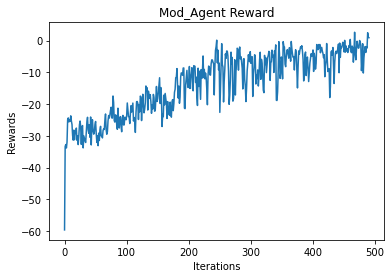

 98%|████████████████████████████████████████████████████████████████████████▋ | 49100/50000 [5:16:59<05:39,  2.65it/s]

Updated Weights
Mean Reward = 7.874000000000003
37


 98%|████████████████████████████████████████████████████████████████████████▊ | 49201/50000 [5:17:32<05:30,  2.42it/s]

Updated Weights
Mean Reward = 10.286000000000001
58


 99%|████████████████████████████████████████████████████████████████████████▉ | 49302/50000 [5:18:02<03:26,  3.38it/s]

Updated Weights
Mean Reward = 11.081000000000001
65


 99%|█████████████████████████████████████████████████████████████████████████ | 49401/50000 [5:18:36<04:45,  2.10it/s]

Updated Weights
Mean Reward = 9.757
56


 99%|█████████████████████████████████████████████████████████████████████████▎| 49500/50000 [5:19:10<01:47,  4.64it/s]

Updated Weights
Mean Reward = 8.343000000000004
52


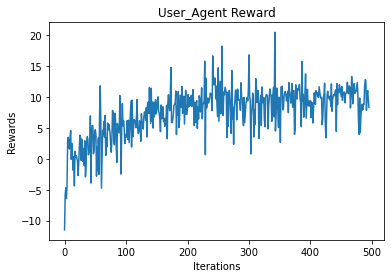

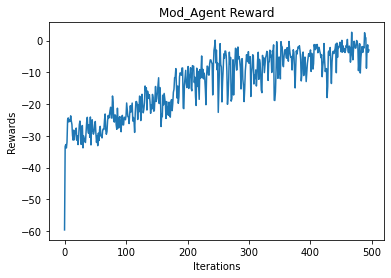

 99%|█████████████████████████████████████████████████████████████████████████▍| 49602/50000 [5:19:50<01:57,  3.40it/s]

Updated Weights
Mean Reward = 6.829
43


 99%|█████████████████████████████████████████████████████████████████████████▌| 49702/50000 [5:20:19<01:05,  4.57it/s]

Updated Weights
Mean Reward = 9.378000000000004
62


100%|█████████████████████████████████████████████████████████████████████████▋| 49802/50000 [5:20:48<00:29,  6.66it/s]

Updated Weights
Mean Reward = 10.005
65


100%|█████████████████████████████████████████████████████████████████████████▊| 49902/50000 [5:21:17<00:39,  2.45it/s]

Updated Weights
Mean Reward = 10.486000000000004
65


100%|██████████████████████████████████████████████████████████████████████████| 50000/50000 [5:21:53<00:00,  2.59it/s]


In [5]:
# user_agent.model.load_weights('user_agent.h5')
rewards = []
mean_rewards = []
max_steps = 40
reached = 0
max_reached = 0
mod_rewards = []
mean_mod_rewards = []
for epoch in tqdm(range(50000)):
    done = False
    episode_reward = 0
    episode_reward_mod = 0
    step = 0
    start, dest = env.give_start_dest()
    state = [start[0], start[1], dest[0], dest[1]]
    mod_state = []    #deque(maxlen = prev_timesteps)
    while not done and step<max_steps:
        state = np.array(state)
        next_state, reward, done, mod_reward = user_agent.play_one_step(env, state, mod_agent, mod_state)
        state = next_state
        episode_reward+=reward
        episode_reward_mod+=mod_reward
        step+=1
        if done:
            reached+=1
            
    if epoch>50:
        user_agent.train()
        mod_agent.train()
    
    if epoch>50 and epoch%100==0:
        user_agent.target_model.set_weights(user_agent.model.get_weights())
        mod_agent.target_model.set_weights(mod_agent.model.get_weights())
        print('Updated Weights')
        
    if epoch>50 and epoch%1000==0:
        mod_agent.epsilon*=0.9
        user_agent.epsilon*=0.9

    mean_rewards.append(episode_reward)
    mean_mod_rewards.append(episode_reward_mod)
    
    if epoch%100==0:
        rewards.append(np.mean(mean_rewards))
        mod_rewards.append(np.mean(mean_mod_rewards))
        mean_rewards = []
        mean_mod_rewards = []
        print(f'Mean Reward = {rewards[-1]}')
        print(reached)
        if reached>max_reached:
            print('Saved Weights')
            max_reached = reached
            user_agent.model.save(f'models\\user_agent_{epoch}.h5')
            mod_agent.model.save(f'models\\mod_agent_{epoch}.h5')
        reached = 0
        
    if epoch%500==0 and epoch:
        plt.plot(rewards)
        plt.xlabel('Iterations')
        plt.ylabel('Rewards')
        plt.title('User_Agent Reward')
        plt.show()
        
        plt.plot(mod_rewards)
        plt.xlabel('Iterations')
        plt.ylabel('Rewards')
        plt.title('Mod_Agent Reward')
        plt.show()
    

In [6]:
# user_agent.model = tf.keras.models.load_model('user_agent.h5')
# mod_agent.model = tf.keras.models.load_model('mod_agent.h5')

In [7]:
user_agent.epsilon = 0
done = False
episode_reward = 0
step = 0
start, dest = env.give_start_dest()
state = [start[0], start[1], dest[0], dest[1]]
max_steps = 40
mod_state = []
while not done and step<max_steps:
    state = np.array(state)
    print(state)
    next_state, reward, done, reward_mod = user_agent.play_one_step(env, state, mod_agent, mod_state)
    state = next_state
    episode_reward+=reward
    step+=1
    if done:
        reached+=1
        
print(episode_reward)

[0.2 0.6 0.2 0.9]
10.9


In [8]:
print(done)

1


In [9]:
next_states = np.array([mod_agent.replay_buffer.state_history[i] for i in [0,120]])
print(next_states.shape)

(2, 4, 6)


In [10]:
print(next_states)

[[[0.  1.  0.  0.  0.6 0. ]
  [1.  0.  0.  0.  0.7 0. ]
  [0.  1.  0.  0.  0.6 0. ]
  [1.  0.  0.  0.  0.7 0. ]]

 [[0.  1.  0.  0.  0.1 0.5]
  [0.  0.  1.  0.  0.4 0.5]
  [0.  1.  0.  0.  0.4 0.2]
  [0.  1.  0.  0.  0.5 0.2]]]


In [11]:
np.array(mod_agent.replay_buffer.state_history)

array([[[0. , 1. , 0. , 0. , 0.6, 0. ],
        [1. , 0. , 0. , 0. , 0.7, 0. ],
        [0. , 1. , 0. , 0. , 0.6, 0. ],
        [1. , 0. , 0. , 0. , 0.7, 0. ]],

       [[1. , 0. , 0. , 0. , 0.7, 0. ],
        [0. , 1. , 0. , 0. , 0.6, 0. ],
        [1. , 0. , 0. , 0. , 0.7, 0. ],
        [0. , 1. , 0. , 0. , 0.6, 0. ]],

       [[0. , 1. , 0. , 0. , 0.6, 0. ],
        [1. , 0. , 0. , 0. , 0.7, 0. ],
        [0. , 1. , 0. , 0. , 0.6, 0. ],
        [1. , 0. , 0. , 0. , 0.7, 0. ]],

       ...,

       [[0. , 1. , 0. , 0. , 0.2, 0.3],
        [0. , 1. , 0. , 0. , 0.3, 0.3],
        [0. , 1. , 0. , 0. , 0.4, 0.3],
        [0. , 0. , 1. , 0. , 0.5, 0.3]],

       [[0. , 1. , 0. , 0. , 0.3, 0.3],
        [0. , 1. , 0. , 0. , 0.4, 0.3],
        [0. , 0. , 1. , 0. , 0.5, 0.3],
        [0. , 1. , 0. , 0. , 0.5, 0.2]],

       [[0. , 0. , 0. , 1. , 0. , 0.3],
        [0. , 0. , 0. , 1. , 0. , 0.6],
        [0. , 1. , 0. , 0. , 0. , 0.9],
        [0. , 1. , 0. , 0. , 0.1, 0.9]]])

In [12]:
user_agent.model.save('user_agent.h5')
mod_agent.model.save('mod_agent.h5')